In [1]:
# Library loading
%matplotlib inline

import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import matplotlib, torch, time, h5py
import numpy as np

from sklearn.metrics import mean_squared_error

import neuravi

import structupy as spy
import viscopy as vp

device = torch.device('cpu') #get_default_device()
print(device)

cpu


In [2]:
### Load dataset

path_data = "./data/DataSet_0p20val.hdf5"
path_raman = "./data/NKAS_Raman.hdf5"
path_density = "./data/NKAS_density.hdf5"
path_optical = "./data/NKAS_optical.hdf5"

ds = neuravi.data_loader(path_data,path_raman,path_density,path_optical,device)


/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [3]:
# Declare model

class models:
    """custom global model predictions

    """
    def __init__(self, path, name_models, device):
        
        self.device = device
        self.n_models = len(name_models)
        self.models = [None for _ in range(self.n_models)]
        
        for i in range(self.n_models):
            name = name_models[i]
            
            # Extract arch
            nb_layers = int(name[name.find("l")+1:name.find("_")])
            nb_neurons = int(name[name.find("n")+1:name.rfind("_")])
            p_drop = float(name[name.find("p")+1:name.rfind(".")])
            
            self.models[i] = neuravi.model(4,nb_neurons,nb_layers,ds.nb_channels_raman,p_drop=p_drop) 
            self.models[i].load_state_dict(torch.load(path+name,map_location='cpu'))
            self.models[i].eval()
            
    def predict(self,method,X, T=[1000.0], lbd= [500.0]):
        
        X = torch.Tensor(X).to(self.device)
        T = torch.Tensor(T).to(self.device)
        lbd = torch.Tensor(lbd).to(self.device)
        
        if method == "raman_pred":    
            out = np.zeros((len(X),850,self.n_models)) # problem is defined with a X raman shift of 850 values
            for i in range(self.n_models):
                out[:,:,i] = getattr(self.models[i],method)(X).cpu().detach().numpy()
            return out
        else:
            out = np.zeros((len(X),self.n_models))
            
        if method in frozenset(('ag', 'myega', 'am', 'cg')):
            for i in range(self.n_models):
                out[:,i] = getattr(self.models[i],method)(X,T).cpu().detach().numpy().reshape(-1)
        elif method == "sellmeier":
            for i in range(self.n_models):
                out[:,i] = getattr(self.models[i],method)(X,lbd).cpu().detach().numpy().reshape(-1)           
        else:
            for i in range(self.n_models):
                out[:,i] = getattr(self.models[i],method)(X).cpu().detach().numpy().reshape(-1)
        
        return out
                    

# Loading the models

In [4]:
path = "./model/best/"
name_list = pd.read_csv("./model/best/best_list.csv").loc[:,"name"]
neuralmodel = models(path, name_list, device)

# Test figure

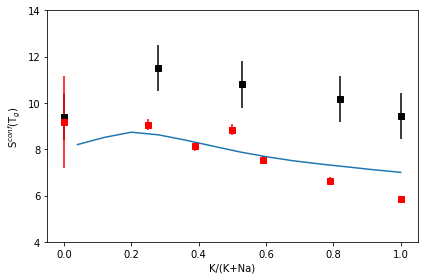

In [5]:
plt.xlabel("K/(K+Na)")
plt.ylabel("S$^{conf}$(T$_g$)")
plt.ylim(4,14)

plt.errorbar(np.array([0,0.28,0.53,0.82,1.0]),np.array([32.91,40.31,37.81,35.59,32.99])/7.0*2.0,
    yerr = 1.0, fmt="ks",
    label="Richet, 1984")

## endmember silicate
na2o = np.arange(0.,0.125,0.01)
k2o = 0.125-na2o
sio2 = np.ones(len(na2o))*0.75
al2o3 = np.ones(len(na2o))*0.125

X_visu_ = np.vstack([sio2,al2o3,na2o,k2o]).T
X_visu_.shape

plt.plot(X_visu_[:,3]/(X_visu_[:,2]+X_visu_[:,3]),neuralmodel.predict("sctg",X_visu_).mean(axis=1),label="NN model")

plt.xlabel("K/(K+Na)")
plt.ylabel("S$^{conf}$(T$_g$)")
plt.ylim(4,14)

plt.errorbar(np.array([0,0.25,0.39,0.50,0.59,0.79,1.00]),
             np.array([9.17,9.06,8.12,8.84,7.54,6.63,5.83]),
    yerr = np.array([2.,0.23,0.20,0.23,0.18,0.15,0.11]), fmt="s", color="r",
    label="Le Losq et al., 2017")

plt.tight_layout()

# Errors on viscosity

In [59]:
criterion = torch.nn.MSELoss()

y_ag_train = neuralmodel.predict("ag",ds.x_visco_train,ds.T_visco_train)
y_ag_valid = neuralmodel.predict("ag",ds.x_visco_valid,ds.T_visco_valid)
y_ag_test = neuralmodel.predict("ag",ds.x_visco_test,ds.T_visco_test)

y_myega_train = neuralmodel.predict("myega",ds.x_visco_train,ds.T_visco_train)
y_myega_valid = neuralmodel.predict("myega",ds.x_visco_valid,ds.T_visco_valid)
y_myega_test = neuralmodel.predict("myega",ds.x_visco_test,ds.T_visco_test)

y_am_train = neuralmodel.predict("am",ds.x_visco_train,ds.T_visco_train)
y_am_valid = neuralmodel.predict("am",ds.x_visco_valid,ds.T_visco_valid)
y_am_test = neuralmodel.predict("am",ds.x_visco_test,ds.T_visco_test)

y_cg_train = neuralmodel.predict("cg",ds.x_visco_train,ds.T_visco_train)
y_cg_valid = neuralmodel.predict("cg",ds.x_visco_valid,ds.T_visco_valid)
y_cg_test = neuralmodel.predict("cg",ds.x_visco_test,ds.T_visco_test)

ag_after_train = np.sqrt(mean_squared_error(y_ag_train.mean(axis=1), ds.y_visco_train.detach().numpy()))
ag_after_valid = np.sqrt(mean_squared_error(y_ag_valid.mean(axis=1), ds.y_visco_valid.detach().numpy()))
ag_after_test = np.sqrt(mean_squared_error(y_ag_test.mean(axis=1), ds.y_visco_test.detach().numpy()))

print('AG train loss after training' , ag_after_train)
print('AG valid loss after training' , ag_after_valid)
print('AG test loss after training' , ag_after_test)
print('')

myega_after_train = np.sqrt(mean_squared_error(y_myega_train.mean(axis=1), ds.y_visco_train.detach().numpy()))
myega_after_valid = np.sqrt(mean_squared_error(y_myega_valid.mean(axis=1), ds.y_visco_valid.detach().numpy()))
myega_after_test = np.sqrt(mean_squared_error(y_myega_test.mean(axis=1), ds.y_visco_test.detach().numpy()))

print('myega train loss after training' , myega_after_train)
print('myega valid loss after training' , myega_after_valid)
print('myega test loss after training' , myega_after_test)
print('')

am_after_train = np.sqrt(mean_squared_error(y_am_train.mean(axis=1), ds.y_visco_train.detach().numpy()))
am_after_valid = np.sqrt(mean_squared_error(y_am_valid.mean(axis=1), ds.y_visco_valid.detach().numpy()))
am_after_test = np.sqrt(mean_squared_error(y_am_test.mean(axis=1), ds.y_visco_test.detach().numpy()))

print('am train loss after training' , am_after_train)
print('am valid loss after training' , am_after_valid)
print('am test loss after training' , am_after_test)
print('')

cg_after_train = np.sqrt(mean_squared_error(y_cg_train.mean(axis=1), ds.y_visco_train.detach().numpy()))
cg_after_valid = np.sqrt(mean_squared_error(y_cg_valid.mean(axis=1), ds.y_visco_valid.detach().numpy()))
cg_after_test = np.sqrt(mean_squared_error(y_cg_test.mean(axis=1), ds.y_visco_test.detach().numpy()))

print('cg train loss after training' , cg_after_train)
print('cg valid loss after training' , cg_after_valid)
print('cg test loss after training' , cg_after_test)
print('')

# Now we calculate on density and refractive index
ese_density_train = np.sqrt(mean_squared_error(ds.y_density_train.cpu().detach().numpy(),
                           neuralmodel.predict("density",ds.x_density_train).mean(axis=1)))
ese_density_valid = np.sqrt(mean_squared_error(ds.y_density_valid.cpu().detach().numpy(),
                           neuralmodel.predict("density",ds.x_density_valid).mean(axis=1)))
ese_density_test = np.sqrt(mean_squared_error(ds.y_density_test.cpu().detach().numpy(),
                           neuralmodel.predict("density",ds.x_density_test).mean(axis=1)))

ese_ri_train = np.sqrt(mean_squared_error(ds.y_ri_train.cpu().detach().numpy(),
                           neuralmodel.predict("sellmeier",ds.x_ri_train,lbd=ds.lbd_ri_train).mean(axis=1)))
ese_ri_valid = np.sqrt(mean_squared_error(ds.y_ri_valid.cpu().detach().numpy(),
                           neuralmodel.predict("sellmeier",ds.x_ri_valid,lbd=ds.lbd_ri_valid).mean(axis=1)))
ese_ri_test = np.sqrt(mean_squared_error(ds.y_ri_test.cpu().detach().numpy(),
                           neuralmodel.predict("sellmeier",ds.x_ri_test,lbd=ds.lbd_ri_test).mean(axis=1)))

print('density train loss after training' , ese_density_train)
print('density valid loss after training' , ese_density_valid)
print('density test loss after training' , ese_density_test)
print('')

print('refractive index train loss after training' , ese_ri_train)
print('refractive index valid loss after training' , ese_ri_valid)
print('refractive index test loss after training' , ese_ri_test)
print('')


AG train loss after training 0.26881921815695925
AG valid loss after training 0.3183554235528589
AG test loss after training 0.4488844733527283

myega train loss after training 0.2556537499102725
myega valid loss after training 0.370311102417663
myega test loss after training 0.44094114264563383

am train loss after training 0.2505691851502554
am valid loss after training 0.3417763551034915
am test loss after training 0.4379723285505798

cg train loss after training 0.23546372413696512
cg valid loss after training 0.35491291127544455
cg test loss after training 0.43171367775038905

density train loss after training 0.007703812867008499
density valid loss after training 0.01582524042177201
density test loss after training 0.011183635062168166

refractive index train loss after training 0.0032235649016099746
refractive index valid loss after training 0.0034987696843211858
refractive index test loss after training 0.00459274018480533



# Compare with Giordano

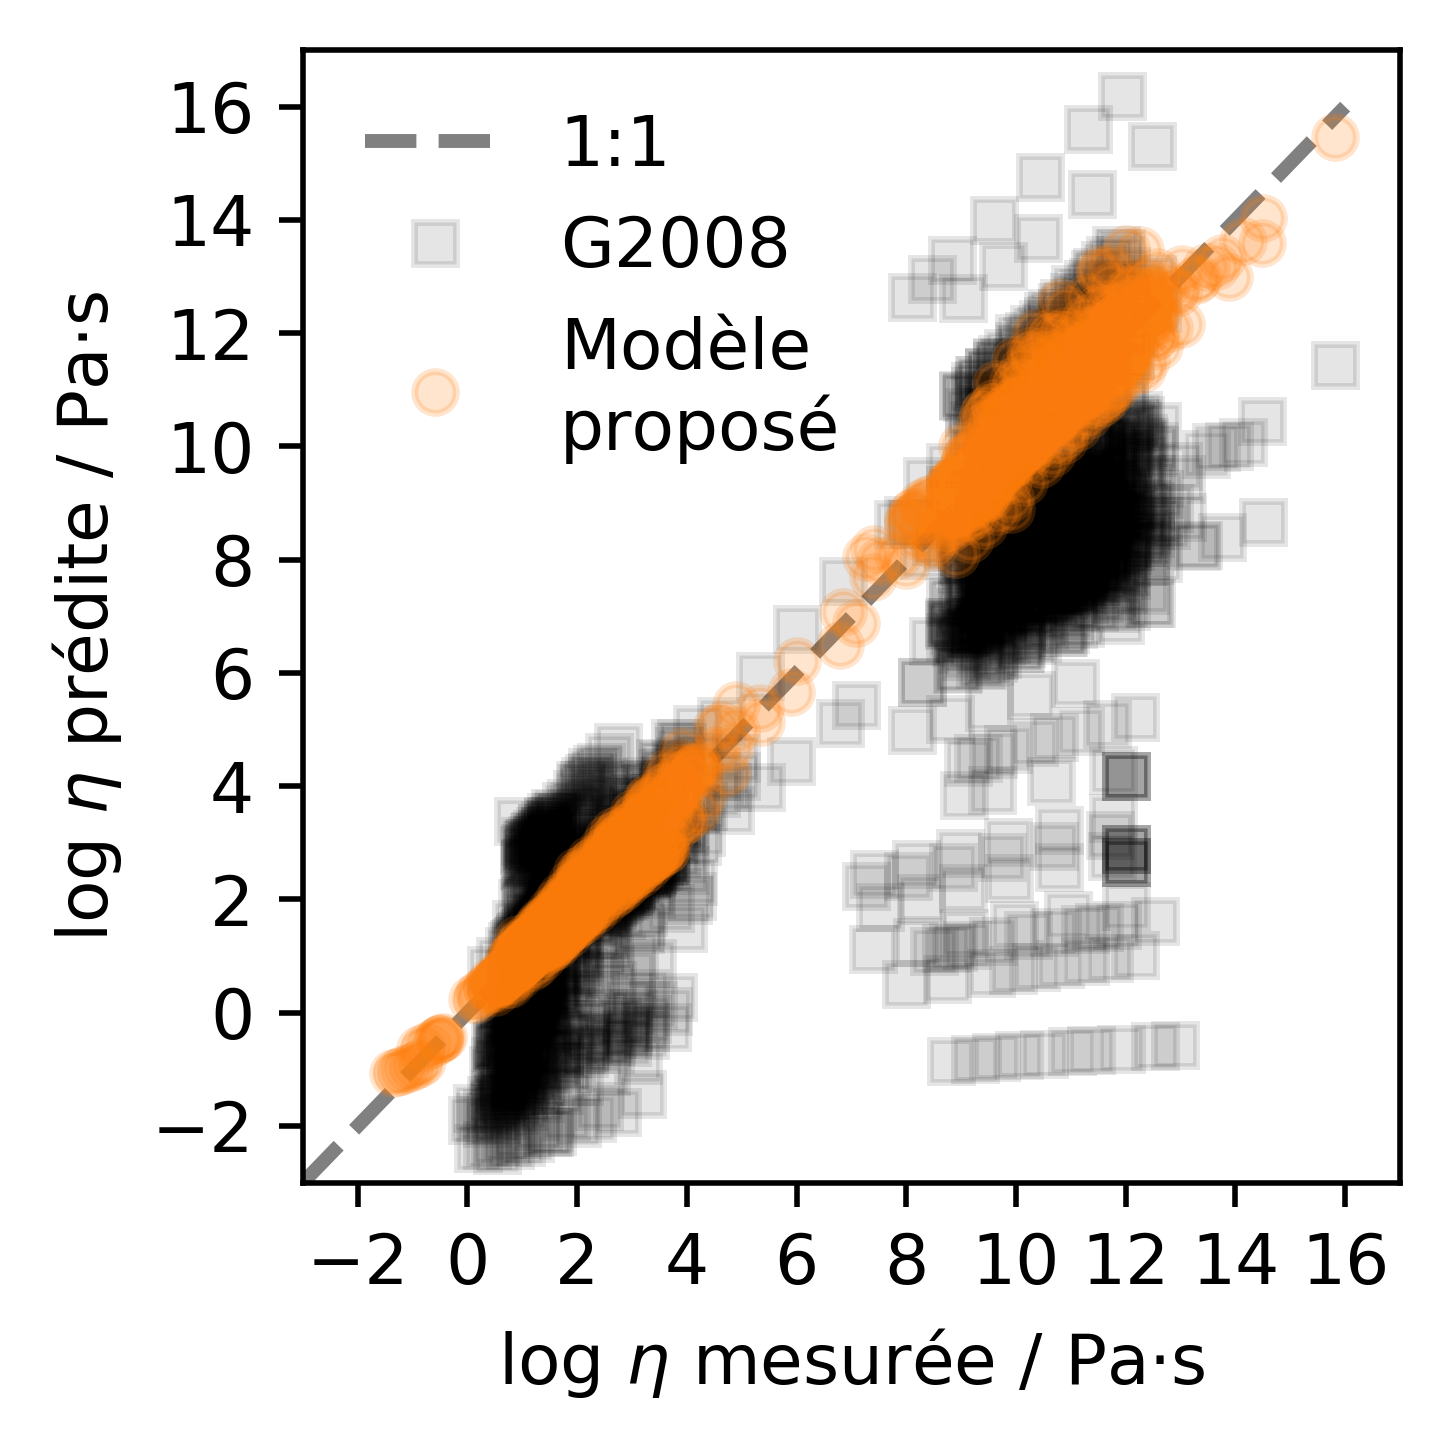

In [7]:
datas_ = pd.read_excel("./data/Database_IPGP.xlsx",sheet_name="VISCO")
datas_ = spy.chimie_control(datas_)
Gmodel = vp.G2008(datas_)

plt.figure(figsize=(3.,3.),dpi=500)

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2,label="1:1")

plt.plot(datas_.viscosity,Gmodel[0],"ks",alpha=0.1,label="G2008")

plt.xticks([-2,0,2,4,6,8,10,12,14,16])
plt.yticks([-2,0,2,4,6,8,10,12,14,16])

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.ylabel("log $\eta$ prédite / Pa$\cdot$s")
plt.xlabel("log $\eta$ mesurée / Pa$\cdot$s")

plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("./figures/Comp_G2008.png")

plt.plot(ds.y_visco_train.cpu().detach().numpy(),y_ag_train.mean(axis=1),"o",color="C1",alpha=0.2,label="Modèle\nproposé")
plt.plot(ds.y_visco_valid.cpu().detach().numpy(),y_ag_valid.mean(axis=1),"o",color="C1",alpha=0.2)
plt.plot(ds.y_visco_test.cpu().detach().numpy(),y_ag_test.mean(axis=1),"o",color="C1",alpha=0.2)
plt.legend(frameon=False)
plt.savefig("./figures/Comp_G2008_LL.png")


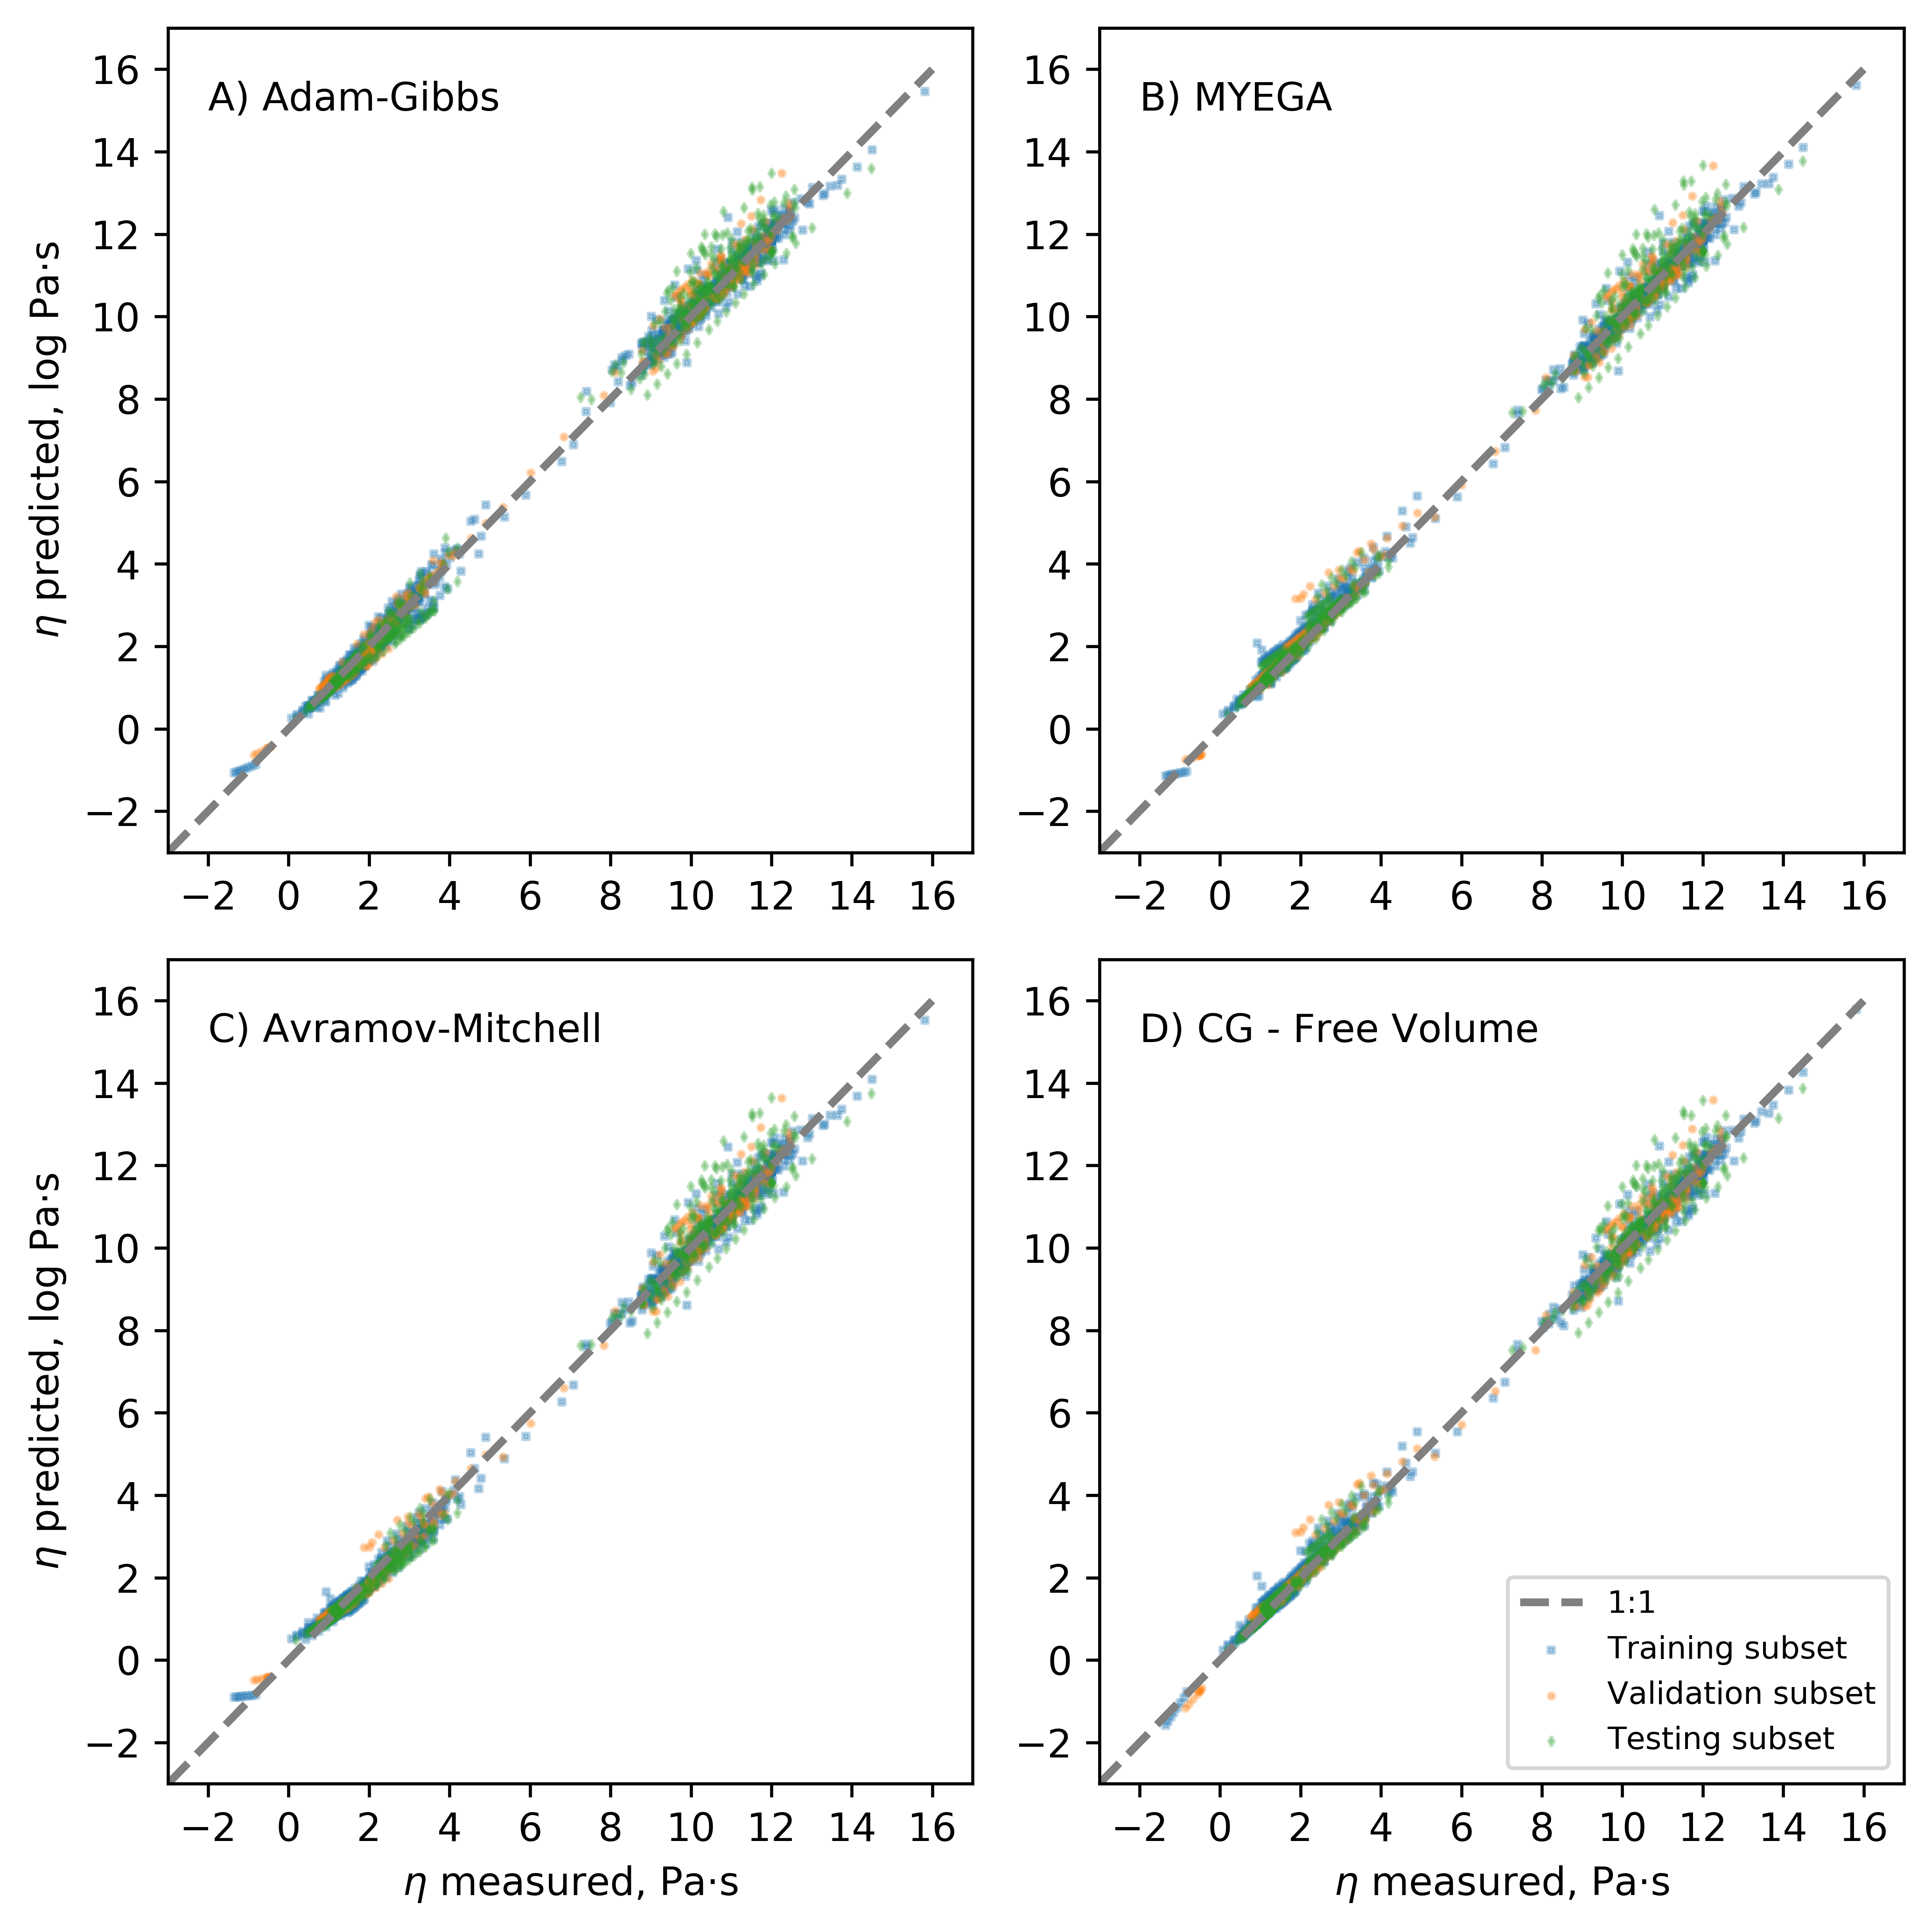

In [8]:
plt.figure(figsize=(7,7),dpi=600)

plt.subplot(2,2,1)
plt.scatter(ds.y_visco_train.cpu().detach().numpy(),y_ag_train.mean(axis=1),marker="s",s=2,alpha=0.3,label="Train")
plt.scatter(ds.y_visco_valid.cpu().detach().numpy(),y_ag_valid.mean(axis=1),marker="o",s=2,alpha=0.3,label="Valid")
plt.scatter(ds.y_visco_test.cpu().detach().numpy(),y_ag_test.mean(axis=1),marker="d",s=2,alpha=0.3,label="Test")

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2)

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.xticks(np.arange(-2,18,2))
plt.yticks(np.arange(-2,18,2))

plt.ylabel("$\eta$ predicted, log Pa$\cdot$s")

plt.annotate("A) Adam-Gibbs",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.subplot(2,2,2)
plt.scatter(ds.y_visco_train.cpu().detach().numpy(),y_myega_train.mean(axis=1),marker="s",s=2,alpha=0.3,label="Train")
plt.scatter(ds.y_visco_valid.cpu().detach().numpy(),y_myega_valid.mean(axis=1),marker="o",s=2,alpha=0.3,label="Valid")
plt.scatter(ds.y_visco_test.cpu().detach().numpy(),y_myega_test.mean(axis=1),marker="d",s=2,alpha=0.3,label="Test")

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2,label="1:1")

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.xticks(np.arange(-2,18,2))
plt.yticks(np.arange(-2,18,2))

plt.annotate("B) MYEGA",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.subplot(2,2,3)
plt.scatter(ds.y_visco_train.cpu().detach().numpy(),y_am_train.mean(axis=1),marker="s",s=2,alpha=0.3,label="Training data subset")
plt.scatter(ds.y_visco_valid.cpu().detach().numpy(),y_am_valid.mean(axis=1),marker="o",s=2,alpha=0.3,label="Validation data subset\n(used to stop training)")
plt.scatter(ds.y_visco_test.cpu().detach().numpy(),y_am_test.mean(axis=1),marker="d",s=2,alpha=0.3,label="Testing data subset\n(never seen during training)")

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2,label="1:1")

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.xticks(np.arange(-2,18,2))
plt.yticks(np.arange(-2,18,2))

plt.xlabel("$\eta$ measured, Pa$\cdot$s")
plt.ylabel("$\eta$ predicted, log Pa$\cdot$s")
plt.annotate("C) Avramov-Mitchell ",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.subplot(2,2,4)
plt.scatter(ds.y_visco_train.cpu().detach().numpy(),y_cg_train.mean(axis=1),marker="s",s=2,alpha=0.3,
            label="Training subset")
plt.scatter(ds.y_visco_valid.cpu().detach().numpy(),y_cg_valid.mean(axis=1),marker="o",s=2,alpha=0.3,
            label="Validation subset")
plt.scatter(ds.y_visco_test.cpu().detach().numpy(),y_cg_test.mean(axis=1),marker="d",s=2,alpha=0.3,
            label="Testing subset")

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2,label="1:1")

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.xticks(np.arange(-2,18,2))
plt.yticks(np.arange(-2,18,2))

plt.xlabel("$\eta$ measured, Pa$\cdot$s")
plt.annotate("D) CG - Free Volume ",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.legend(loc="lower right", fontsize=8)

plt.tight_layout()
plt.savefig("./figures/Figure2.png")

Checking shape...
(50, 4)


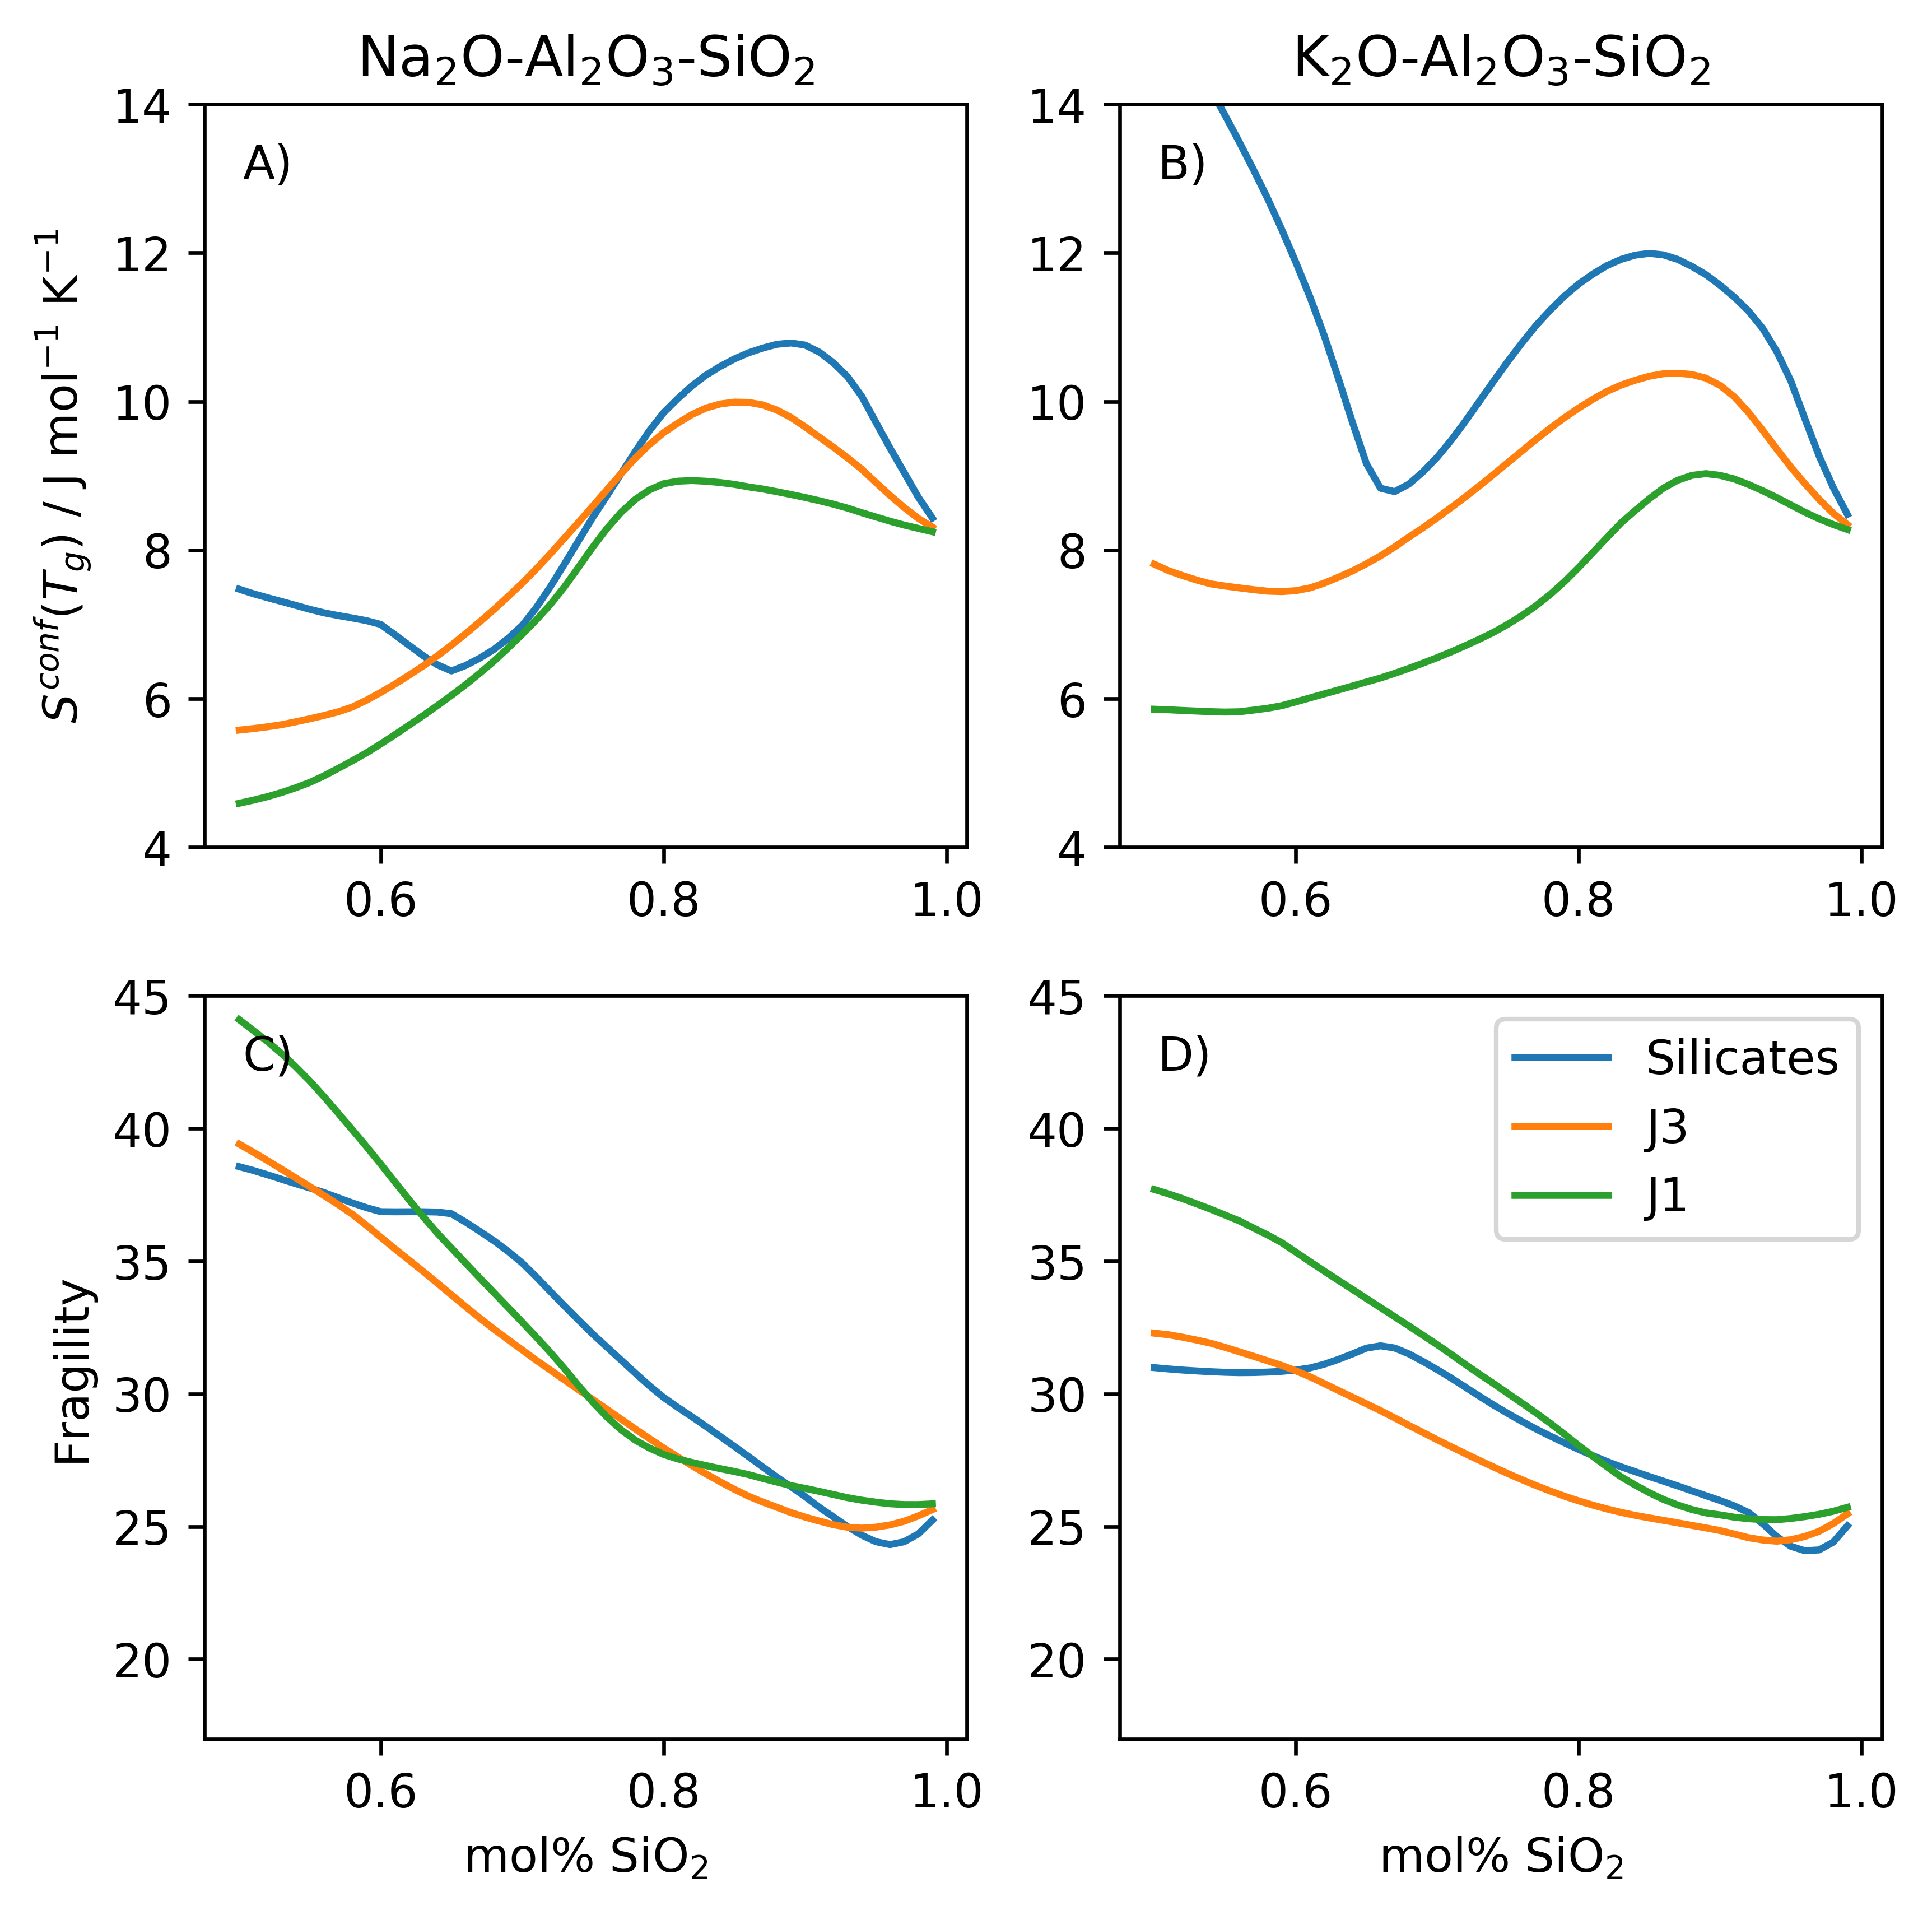

In [9]:
sio2 = np.arange(0.5,1.,0.01)

# order => sio2 al2o3 na2o k2o
X_visu_NAS_sili = np.vstack([sio2,np.zeros(len(sio2)),1.0-sio2,np.zeros(len(sio2))]).T
X_visu_NAS_J3 = np.vstack([sio2,(1.0-sio2)*1.0/3.0, (1.0-sio2)*2.0/3.0,np.zeros(len(sio2))]).T
X_visu_NAS_J1 = np.vstack([sio2,(1.0-sio2)*0.5, (1.0-sio2)*0.5,np.zeros(len(sio2))]).T

X_visu_KAS_sili = np.vstack([sio2,np.zeros(len(sio2)),np.zeros(len(sio2)),1.0-sio2]).T
X_visu_KAS_J3 = np.vstack([sio2,(1.0-sio2)*1.0/3.0,np.zeros(len(sio2)), (1.0-sio2)*2.0/3.0]).T
X_visu_KAS_J1 = np.vstack([sio2,(1.0-sio2)*0.5,np.zeros(len(sio2)), (1.0-sio2)*0.5]).T

Sctg_NAS_sili = neuralmodel.predict("sctg",X_visu_NAS_sili).mean(axis=1)
Sctg_NAS_J3 = neuralmodel.predict("sctg",X_visu_NAS_J3).mean(axis=1)
Sctg_NAS_J1 = neuralmodel.predict("sctg",X_visu_NAS_J1).mean(axis=1)

Sctg_KAS_sili = neuralmodel.predict("sctg",X_visu_KAS_sili).mean(axis=1)
Sctg_KAS_J3 = neuralmodel.predict("sctg",X_visu_KAS_J3).mean(axis=1)
Sctg_KAS_J1 = neuralmodel.predict("sctg",X_visu_KAS_J1).mean(axis=1)

tg_NAS_sili = neuralmodel.predict("tg",X_visu_NAS_sili).mean(axis=1)
tg_NAS_J3 = neuralmodel.predict("tg",X_visu_NAS_J3).mean(axis=1)
tg_NAS_J1 = neuralmodel.predict("tg",X_visu_NAS_J1).mean(axis=1)

tg_KAS_sili = neuralmodel.predict("tg",X_visu_KAS_sili).mean(axis=1)
tg_KAS_J3 = neuralmodel.predict("tg",X_visu_KAS_J3).mean(axis=1)
tg_KAS_J1 = neuralmodel.predict("tg",X_visu_KAS_J1).mean(axis=1)

m_NAS_sili = neuralmodel.predict("fragility",X_visu_NAS_sili).mean(axis=1)
m_NAS_J3 = neuralmodel.predict("fragility",X_visu_NAS_J3).mean(axis=1)
m_NAS_J1 = neuralmodel.predict("fragility",X_visu_NAS_J1).mean(axis=1)

m_KAS_sili = neuralmodel.predict("fragility",X_visu_KAS_sili).mean(axis=1)
m_KAS_J3 = neuralmodel.predict("fragility",X_visu_KAS_J3).mean(axis=1)
m_KAS_J1 = neuralmodel.predict("fragility",X_visu_KAS_J1).mean(axis=1)

print("Checking shape...")
print(X_visu_KAS_J1.shape)

plt.figure(figsize=(6.44,6.44), dpi=600)

plt.subplot(2,2,1) # NAS entropy

plt.plot(X_visu_NAS_sili[:,0],Sctg_NAS_sili,color="C0",label="Silicates")
plt.plot(X_visu_NAS_J3[:,0],Sctg_NAS_J3,color="C1",label="J3")
plt.plot(X_visu_NAS_J1[:,0],Sctg_NAS_J1,color="C2",label="J1")

plt.title(r"Na$_2$O-Al$_2$O$_3$-SiO$_2$")
plt.ylabel("$S^{conf}(T_g)$ / J mol$^{-1}$ K$^{-1}$")
plt.annotate("A)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")
plt.ylim(4,14)

plt.subplot(2,2,2) # KAS entropy

plt.plot(X_visu_KAS_sili[:,0],Sctg_KAS_sili,color="C0",label="Silicates")
plt.plot(X_visu_KAS_J3[:,0],Sctg_KAS_J3,color="C1",label="J3")
plt.plot(X_visu_KAS_J1[:,0],Sctg_KAS_J1,color="C2",label="J1")

plt.title(r"K$_2$O-Al$_2$O$_3$-SiO$_2$")
plt.annotate("B)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")
plt.ylim(4,14)

plt.subplot(2,2,3) # NAS fragility

plt.plot(X_visu_NAS_sili[:,0],m_NAS_sili,color="C0",label="Silicates")
plt.plot(X_visu_NAS_J3[:,0],m_NAS_J3,color="C1",label="J3")
plt.plot(X_visu_NAS_J1[:,0],m_NAS_J1,color="C2",label="J1")

plt.xlabel("mol% SiO$_2$")
plt.ylabel("Fragility")
plt.annotate("C)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")
plt.ylim(17,45)

plt.subplot(2,2,4) # KAS fragility

plt.plot(X_visu_KAS_sili[:,0],m_KAS_sili,color="C0",label="Silicates")
plt.plot(X_visu_KAS_J3[:,0],m_KAS_J3,color="C1",label="J3")
plt.plot(X_visu_KAS_J1[:,0],m_KAS_J1,color="C2",label="J1")
plt.ylim(17,45)

plt.xlabel("mol% SiO$_2$")
plt.annotate("D)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.legend(loc="upper right")

plt.savefig("./figures/Entropy_J_KNAS.png")

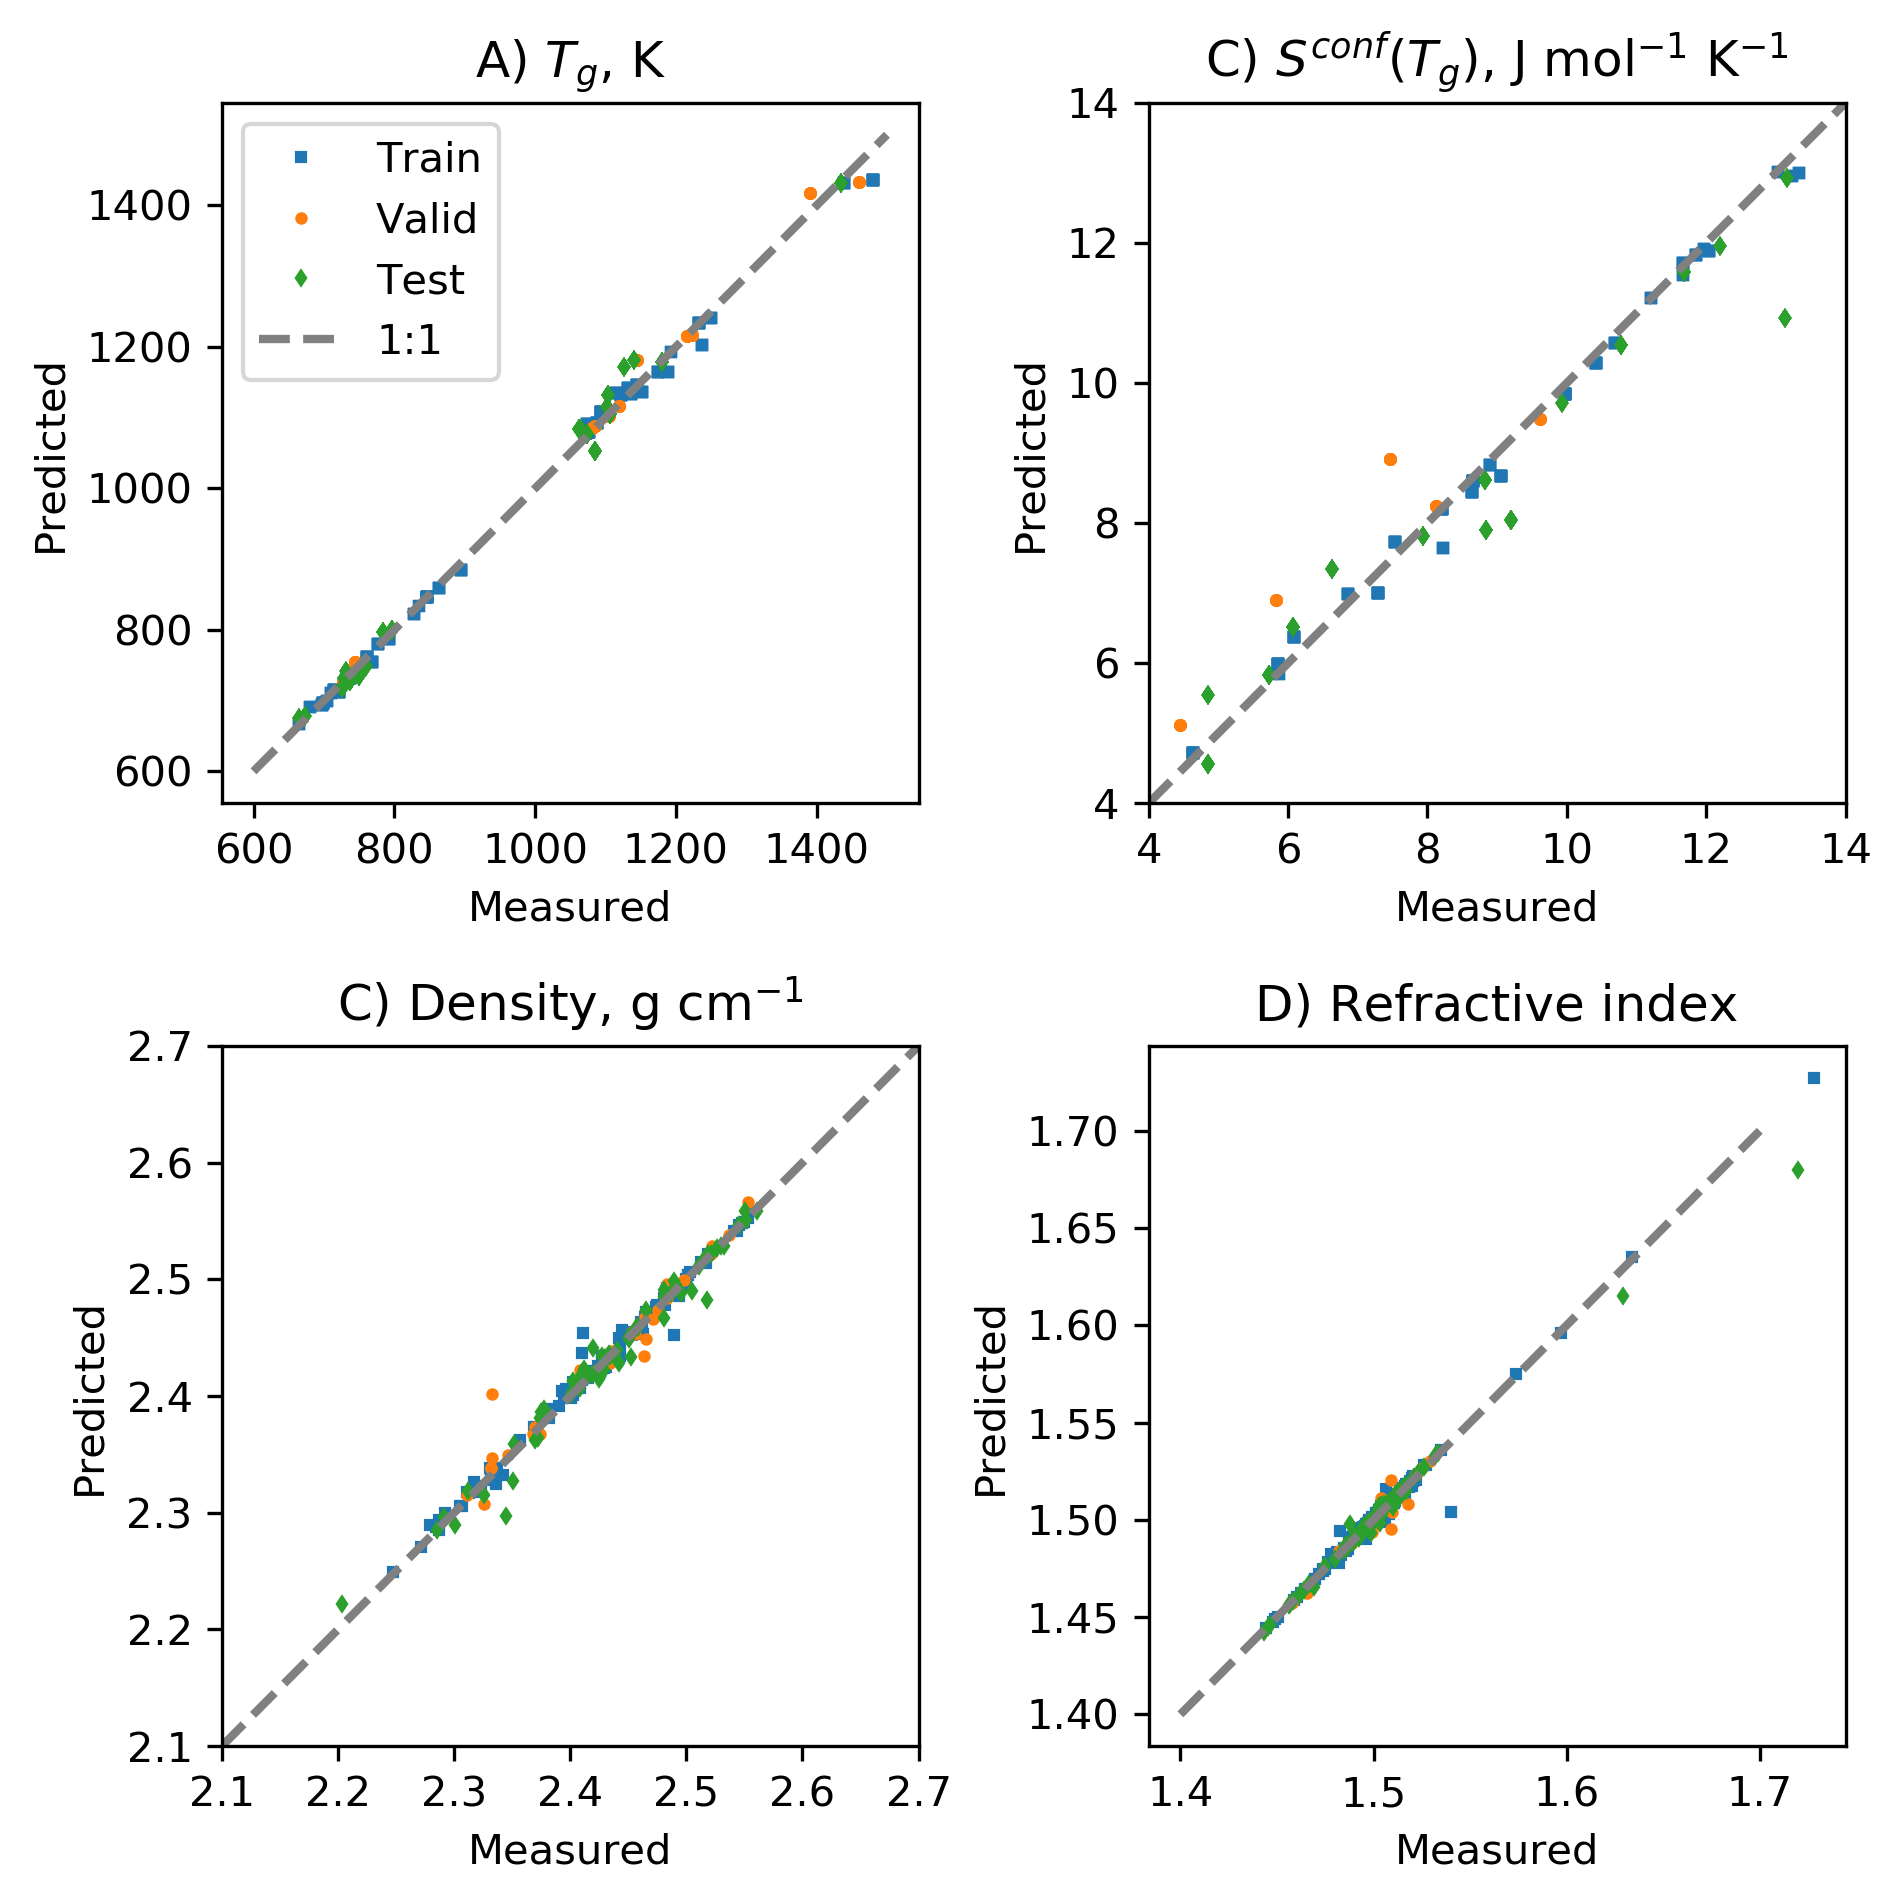

In [10]:
plt.figure(figsize=(6.44,6.44),dpi=300)

tx1 = plt.subplot(2,2,1)
tx1.plot(ds.y_tg_train.cpu().detach().numpy(),neuralmodel.predict("tg",ds.x_tg_train).mean(axis=1),
         "s",linestyle="none",color="C0",markersize=2,label="Train")
tx1.plot(ds.y_tg_valid.cpu().detach().numpy(),neuralmodel.predict("tg",ds.x_tg_valid).mean(axis=1),
         "o",color="C1",markersize=2,label="Valid")
tx1.plot(ds.y_tg_test.cpu().detach().numpy(),neuralmodel.predict("tg",ds.x_tg_test).mean(axis=1),
         "d",color="C2",markersize=2,label="Test")

plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.title(r"A) $T_g$, K")

plt.plot([600,1500],[600,1500],"--",color="grey",linewidth=2,label="1:1")

plt.legend(loc="upper left")

tx2 = plt.subplot(2,2,2)
tx2.plot(ds.y_entro_train.cpu().detach().numpy(),neuralmodel.predict("sctg",ds.x_entro_train).mean(axis=1),
         "s",color="C0",markersize=2,label="Train")
tx2.plot(ds.y_entro_valid.cpu().detach().numpy(),neuralmodel.predict("sctg",ds.x_entro_valid).mean(axis=1),
         "o",color="C1",markersize=2,label="Valid")
tx2.plot(ds.y_entro_test.cpu().detach().numpy(),neuralmodel.predict("sctg",ds.x_entro_test).mean(axis=1),
         "d",color="C2",markersize=2,label="Test")

plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.title(r"C) $S^{conf}(T_g)$, J mol$^{-1}$ K$^{-1}$")
plt.xlim(4,14)
plt.ylim(4,14)
plt.plot([4,14],[4,14],"--",color="grey",linewidth=2,label="1:1")

tx3=plt.subplot(2,2,3)
tx3.plot(ds.y_density_train.cpu().detach().numpy(),neuralmodel.predict("density",ds.x_density_train).mean(axis=1),
         "s",color="C0",markersize=2,label="Train")
tx3.plot(ds.y_density_valid.cpu().detach().numpy(),neuralmodel.predict("density",ds.x_density_valid).mean(axis=1),
         "o",color="C1",markersize=2,label="Valid")
tx3.plot(ds.y_density_test.cpu().detach().numpy(),neuralmodel.predict("density",ds.x_density_test).mean(axis=1),
         "d",color="C2",markersize=2,label="Test")

plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.title(r"C) Density, g cm$^{-1}$")

plt.plot([2.1,2.7],[2.1,2.7],"--",color="grey",linewidth=2,label="1:1")

plt.xlim(2.1,2.7)
plt.ylim(2.1,2.7)
plt.xticks([2.1,2.2,2.3,2.4,2.5,2.6,2.7])
plt.yticks([2.1,2.2,2.3,2.4,2.5,2.6,2.7])

tx4 = plt.subplot(2,2,4)

tx4.plot(ds.y_ri_train.cpu().detach().numpy(),neuralmodel.predict("sellmeier",ds.x_ri_train, lbd=ds.lbd_ri_train).mean(axis=1),
         "s",color="C0",markersize=2,label="Train")
tx4.plot(ds.y_ri_valid.cpu().detach().numpy(),neuralmodel.predict("sellmeier",ds.x_ri_valid, lbd=ds.lbd_ri_valid).mean(axis=1),
         "o",color="C1",markersize=2,label="Valid")
tx4.plot(ds.y_ri_test.cpu().detach().numpy(),neuralmodel.predict("sellmeier",ds.x_ri_test, lbd=ds.lbd_ri_test).mean(axis=1),
         "d",color="C2",markersize=2,label="Test")

plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.title(r"D) Refractive index")

plt.plot([1.4,1.7],[1.4,1.7],"--",color="grey",linewidth=2,label="1:1")

plt.tight_layout()

plt.savefig("./figures/SupplementaryFigure3.png")

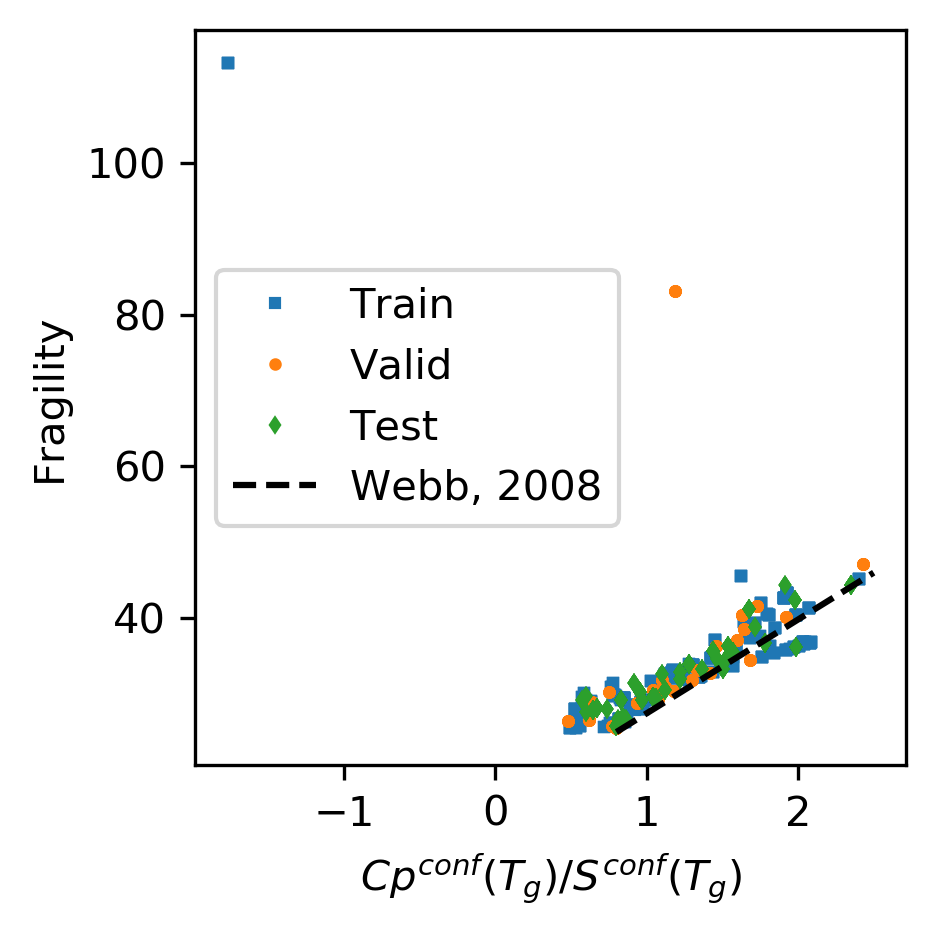

In [45]:
plt.figure(figsize=(3.22,3.22),dpi=300)
# Train

Cpconf = neuralmodel.predict("ap_calc",ds.x_visco_train).mean(axis=1) + neuralmodel.predict("b_calc",ds.x_visco_train).mean(axis=1)* neuralmodel.predict("tg",ds.x_visco_train).mean(axis=1)
Cp_S = Cpconf/neuralmodel.predict("sctg",ds.x_visco_train).mean(axis=1)

plt.plot(Cp_S,neuralmodel.predict("fragility",ds.x_visco_train).mean(axis=1),
         "s",color="C0",markersize=2,label="Train")

# Valid
Cpconf = neuralmodel.predict("ap_calc",ds.x_visco_valid).mean(axis=1) + neuralmodel.predict("b_calc",ds.x_visco_valid).mean(axis=1)* neuralmodel.predict("tg",ds.x_visco_valid).mean(axis=1)
Cp_S = Cpconf/neuralmodel.predict("sctg",ds.x_visco_valid).mean(axis=1)

plt.plot(Cp_S,neuralmodel.predict("fragility",ds.x_visco_valid).mean(axis=1),
         "o",color="C1",markersize=2,label="Valid")

# Test
Cpconf = neuralmodel.predict("ap_calc",ds.x_visco_test).mean(axis=1) + neuralmodel.predict("b_calc",ds.x_visco_test).mean(axis=1)* neuralmodel.predict("tg",ds.x_visco_test).mean(axis=1)
Cp_S = Cpconf/neuralmodel.predict("sctg",ds.x_visco_test).mean(axis=1)

plt.plot(Cp_S,neuralmodel.predict("fragility",ds.x_visco_test).mean(axis=1),
         "d",color="C2",markersize=2,label="Test")

plt.plot([0.8, 2.5],[25., 46],"k--",label="Webb, 2008")

plt.xlabel(r"$Cp^{conf}(T_g)/S^{conf}(T_g)$")
plt.ylabel("Fragility")

plt.legend()
plt.tight_layout()
plt.savefig("./figures/SupplementaryFigure4.png")

# Raman figure

Training error on Raman dataset is 6.482449319708358
Training error on Raman dataset is 8.804836403739005


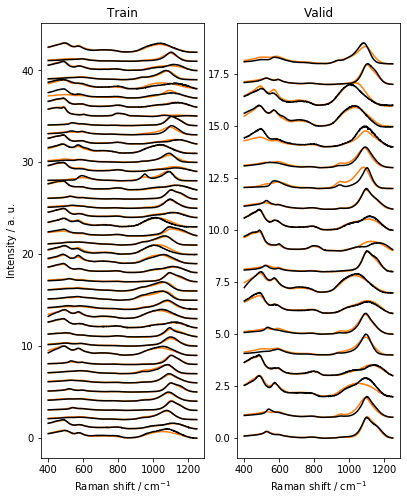

In [56]:
x_raman_shift = np.arange(400.,1250.,1.0) # our real x axis, for resampling

raman_train_predictions = neuralmodel.predict("raman_pred",ds.x_raman_train).mean(axis=2)
raman_valid_predictions = neuralmodel.predict("raman_pred",ds.x_raman_valid).mean(axis=2)

plt.figure(figsize=(6.44,8))

###
plt.subplot(1,2,1)
plt.title("Train")
Raman_error = 0.
shift = 0.
for i in range(ds.x_raman_train.shape[0]):
    Raman_error += np.sum((neuralmodel.predict("raman_pred",ds.x_raman_train[i,:]).mean(axis=2)-ds.y_raman_train[i,:].detach().numpy())**2)/np.sum(ds.y_raman_train[i,:].detach().numpy())
    plt.plot(x_raman_shift,raman_train_predictions[i,:]+shift,color="C1")
    plt.plot(x_raman_shift,ds.y_raman_train[i,:].detach().numpy()+shift,"k-")
    shift += 1.
plt.xlabel("Raman shift / cm$^{-1}$")
plt.ylabel("Intensity / a. u.")

print("Training error on Raman dataset is {}".format(Raman_error/ds.x_raman_train.shape[0]*100))
###
plt.subplot(1,2,2)
plt.title("Valid")
Raman_error = 0.
shift = 0.
for i in range(ds.x_raman_valid.shape[0]):
    Raman_error += np.sum((neuralmodel.predict("raman_pred",ds.x_raman_valid[i,:]).mean(axis=2)-ds.y_raman_valid[i,:].detach().numpy())**2)/np.sum(ds.y_raman_valid[i,:].detach().numpy())
    plt.plot(x_raman_shift,raman_valid_predictions[i,:]+shift,color="C1")
    plt.plot(x_raman_shift,ds.y_raman_valid[i,:].detach().numpy()+shift,"k-")
    shift += 1.

plt.xlabel("Raman shift / cm$^{-1}$")
plt.savefig("./figures/SupplementaryFigure6_Raman_preds.pdf")

print("Training error on Raman dataset is {}".format(Raman_error/ds.x_raman_valid.shape[0]*100))
#idx_min_train = np.where(sp[:,1] == np.min(sp[(800<= sp[:,0])&(sp[:,0]<=1000),1]))[0][0]

Rr_train = np.trapz(ds.y_raman_train.detach().numpy()[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(ds.y_raman_train.detach().numpy()[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)
Rr_valid = np.trapz(ds.y_raman_valid.detach().numpy()[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(ds.y_raman_valid.detach().numpy()[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)

Rr_train_pred = np.trapz(raman_train_predictions[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(raman_train_predictions[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)
Rr_valid_pred = np.trapz(raman_valid_predictions[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(raman_valid_predictions[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)


In [15]:
visu_KAS_Raman_sili = neuralmodel.predict("raman_pred",X_visu_KAS_sili).mean(axis=2)
visu_KAS_Raman_J3 = neuralmodel.predict("raman_pred",X_visu_KAS_J3).mean(axis=2)
visu_KAS_Raman_J1 = neuralmodel.predict("raman_pred",X_visu_KAS_J1).mean(axis=2)

visu_NAS_Raman_sili = neuralmodel.predict("raman_pred",X_visu_NAS_sili).mean(axis=2)
visu_NAS_Raman_J3 = neuralmodel.predict("raman_pred",X_visu_NAS_J3).mean(axis=2)
visu_NAS_Raman_J1 = neuralmodel.predict("raman_pred",X_visu_NAS_J1).mean(axis=2)

Rr_KAS_sili = np.trapz(visu_KAS_Raman_sili[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(visu_KAS_Raman_sili[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)
Rr_KAS_J3 = np.trapz(visu_KAS_Raman_J3[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(visu_KAS_Raman_J3[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)
Rr_KAS_J1 = np.trapz(visu_KAS_Raman_J1[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(visu_KAS_Raman_J1[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)

Rr_NAS_sili = np.trapz(visu_NAS_Raman_sili[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(visu_NAS_Raman_sili[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)
Rr_NAS_J3 = np.trapz(visu_NAS_Raman_J3[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(visu_NAS_Raman_J3[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)
Rr_NAS_J1 = np.trapz(visu_NAS_Raman_J1[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(visu_NAS_Raman_J1[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)


# Visualize correlations

<Figure size 1080x1080 with 0 Axes>

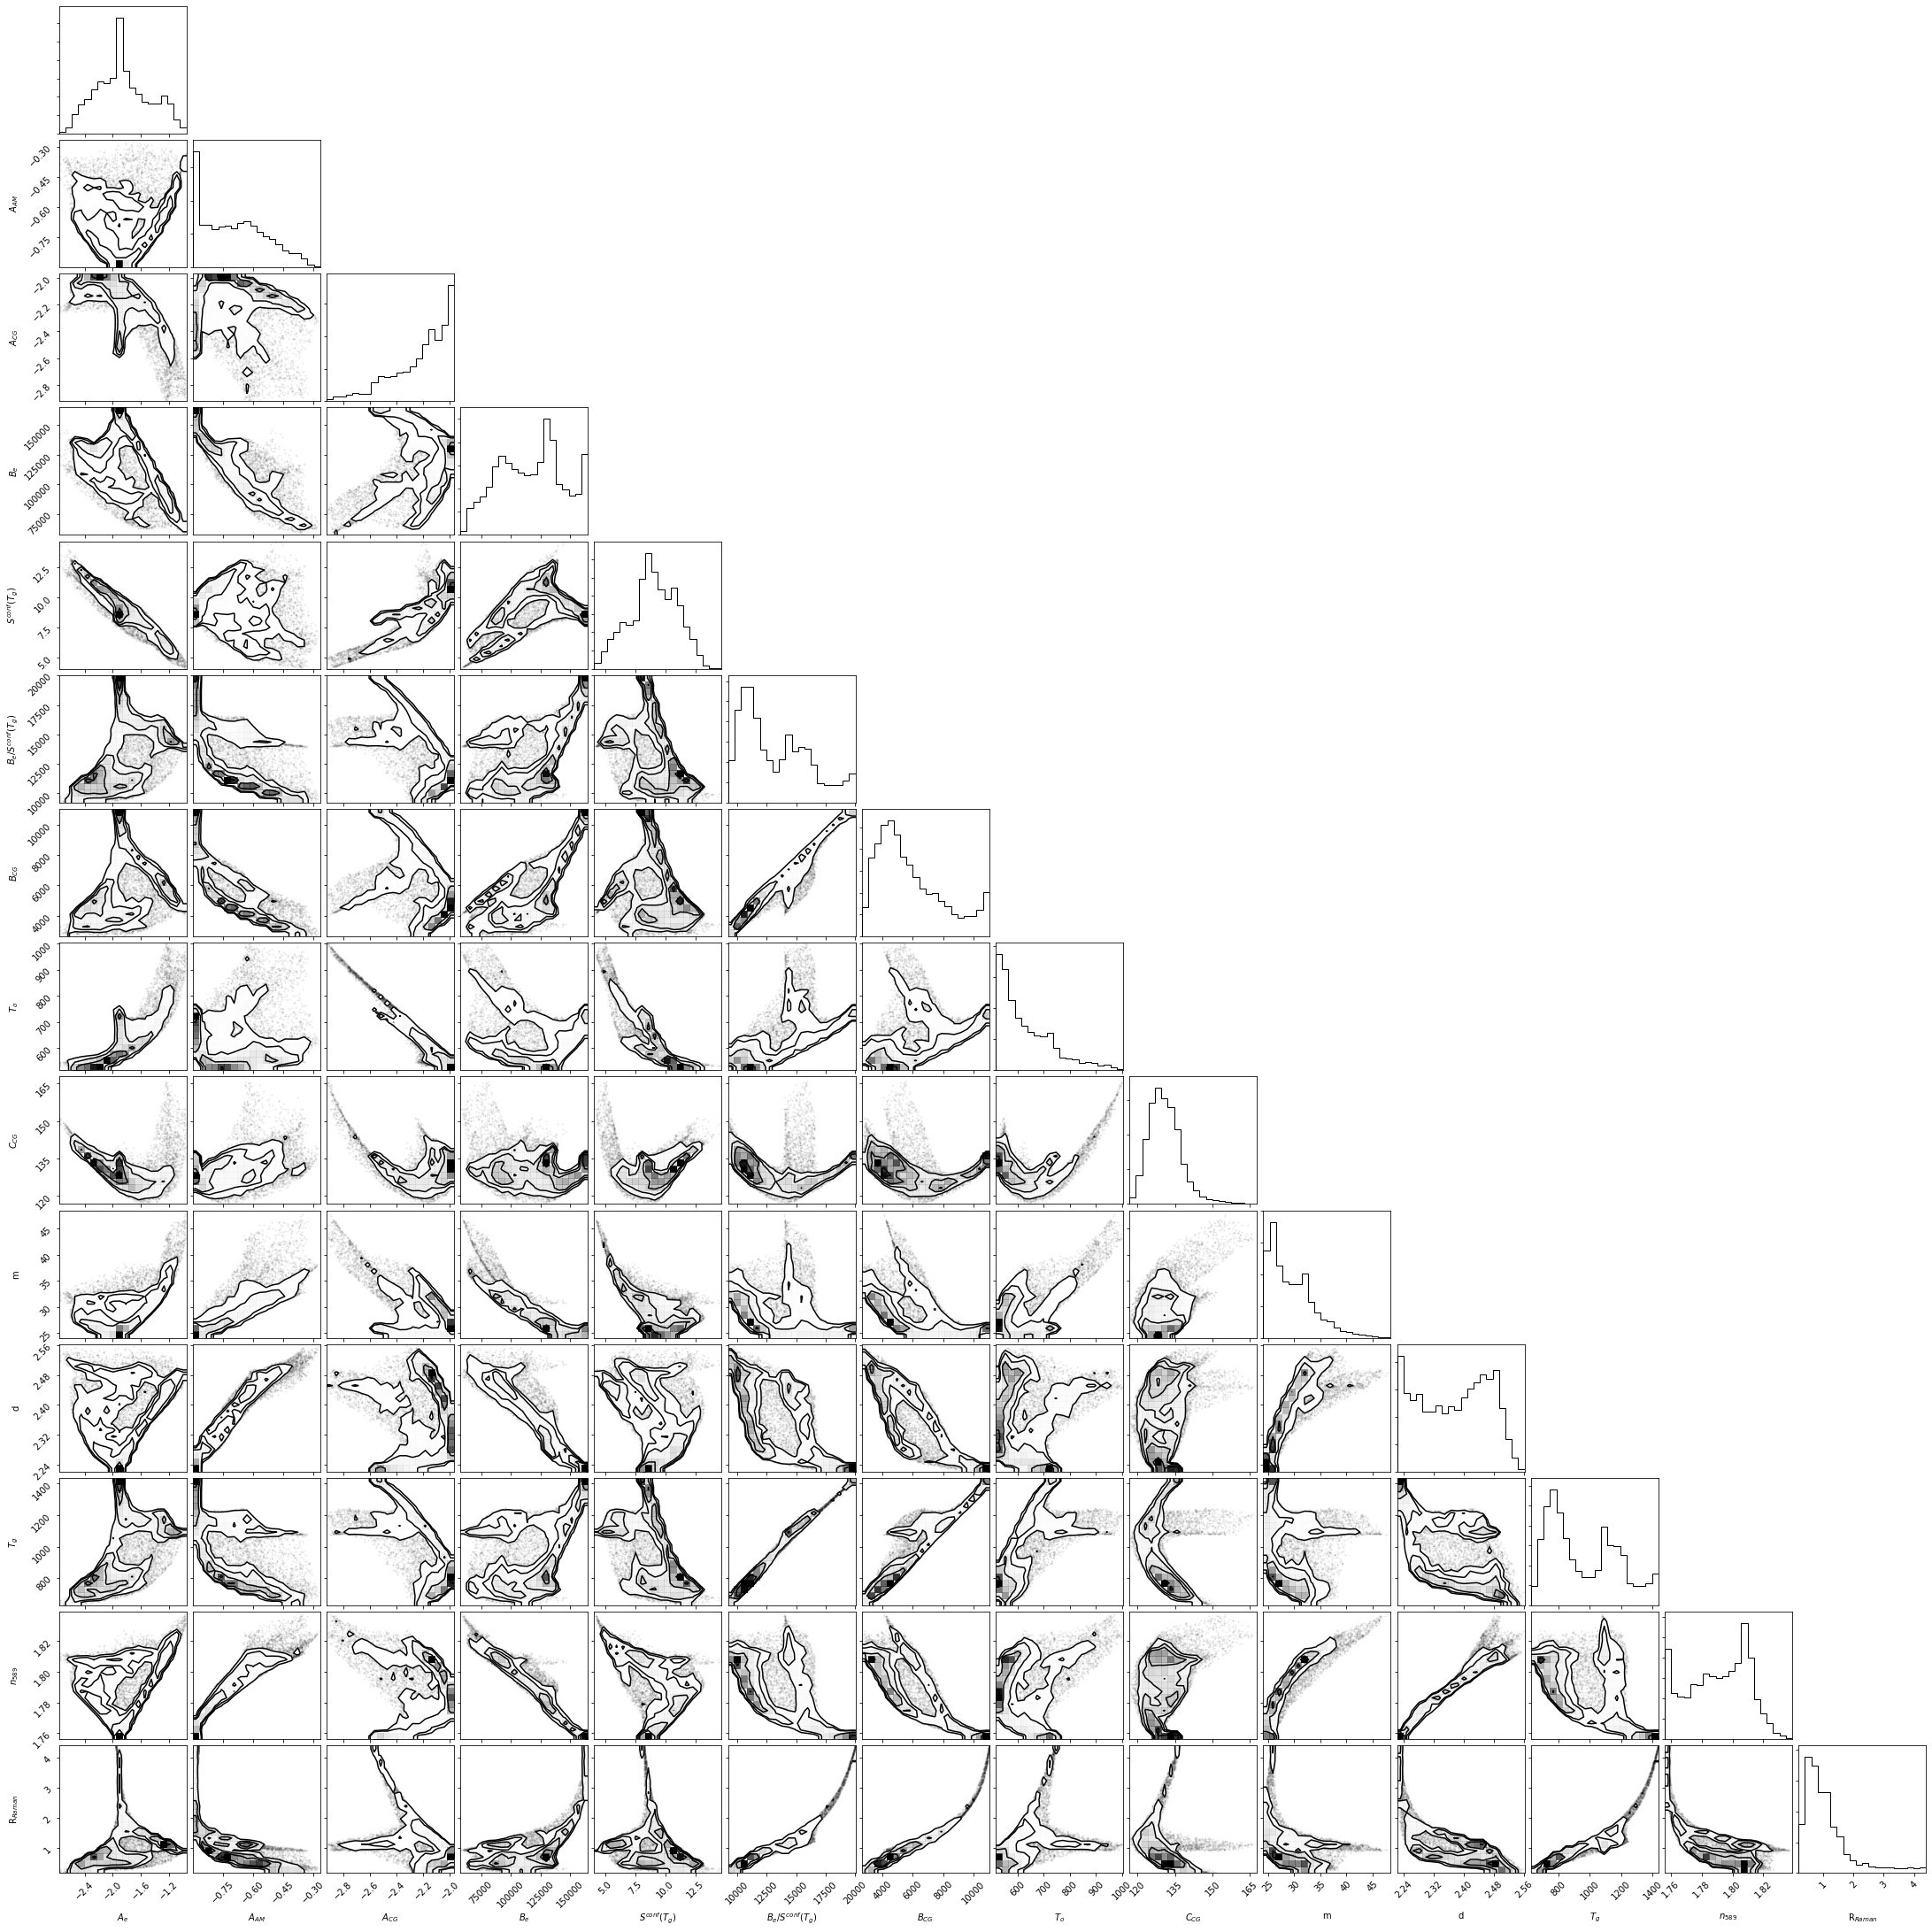

In [25]:
nb_samples = 10000
sio2_gen = np.random.random_sample(nb_samples)*0.5 + 0.5

reminder = 1.0 - sio2_gen

R_MAl = np.random.random_sample(nb_samples)*(1.0-0.4) + 0.4 # ratio of alkalis to Al

R_XK = np.random.random_sample(nb_samples) # ratio K/(K+Na)

al2o3_gen = (1.0 - R_MAl)*reminder

reminder = 1 - sio2_gen - al2o3_gen

na2o_gen = reminder*(1.0-R_XK)
k2o_gen = 1 - sio2_gen - al2o3_gen - na2o_gen

X_gen = pd.DataFrame()
X_gen["sio2"] = sio2_gen
X_gen["al2o3"] = al2o3_gen
X_gen["na2o"] = na2o_gen
X_gen["k2o"] = k2o_gen
X_rec = X_gen.copy()
X_gen = torch.Tensor(X_gen.values).to(device)

Raman_gen = neuralmodel.predict("raman_pred",X_gen).mean(axis=2)

Rr_gen = np.trapz(Raman_gen[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(Raman_gen[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)

samples = np.concatenate((neuralmodel.predict("ae",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("a_am",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("a_cg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("be",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("sctg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("be",X_gen).mean(axis=1).reshape(-1,1)/neuralmodel.predict("sctg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("b_cg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("to_cg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("c_cg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("fragility",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("density",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("tg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("sellmeier",X_gen,lbd=589.0*np.ones((len(X_gen),1))).mean(axis=1).reshape(-1,1),
                          Rr_gen.reshape(-1,1)
                         ),axis=1)

labels = [r"$A_e$", r"$A_{AM}$", r"$A_{CG}$", 
          r"$B_e$", r"$S^{conf}(T_g)$", r"$B_e/S^{conf}(T_g)$", 
          r"$B_{CG}$", r"$T_o$", r"$C_{CG}$", 
          r"m", r"d", r"$T_g$",r"$n_{589}$",r"R$_{Raman}$"]

import corner

plt.figure(figsize=(15,15))
corner.corner(samples, labels=labels)

plt.savefig("./figures/Correlations.pdf")

In [26]:
from scipy.stats import spearmanr
df_samples = pd.DataFrame(data= samples, columns=labels)
sp_corr = df_samples.corr(method="spearman")
# 'RdBu_r' & 'BrBG' are other good diverging colormaps
sp_corr.style.background_gradient(cmap='coolwarm')

100%|██████████| 10000/10000 [00:36<00:00, 277.29it/s]


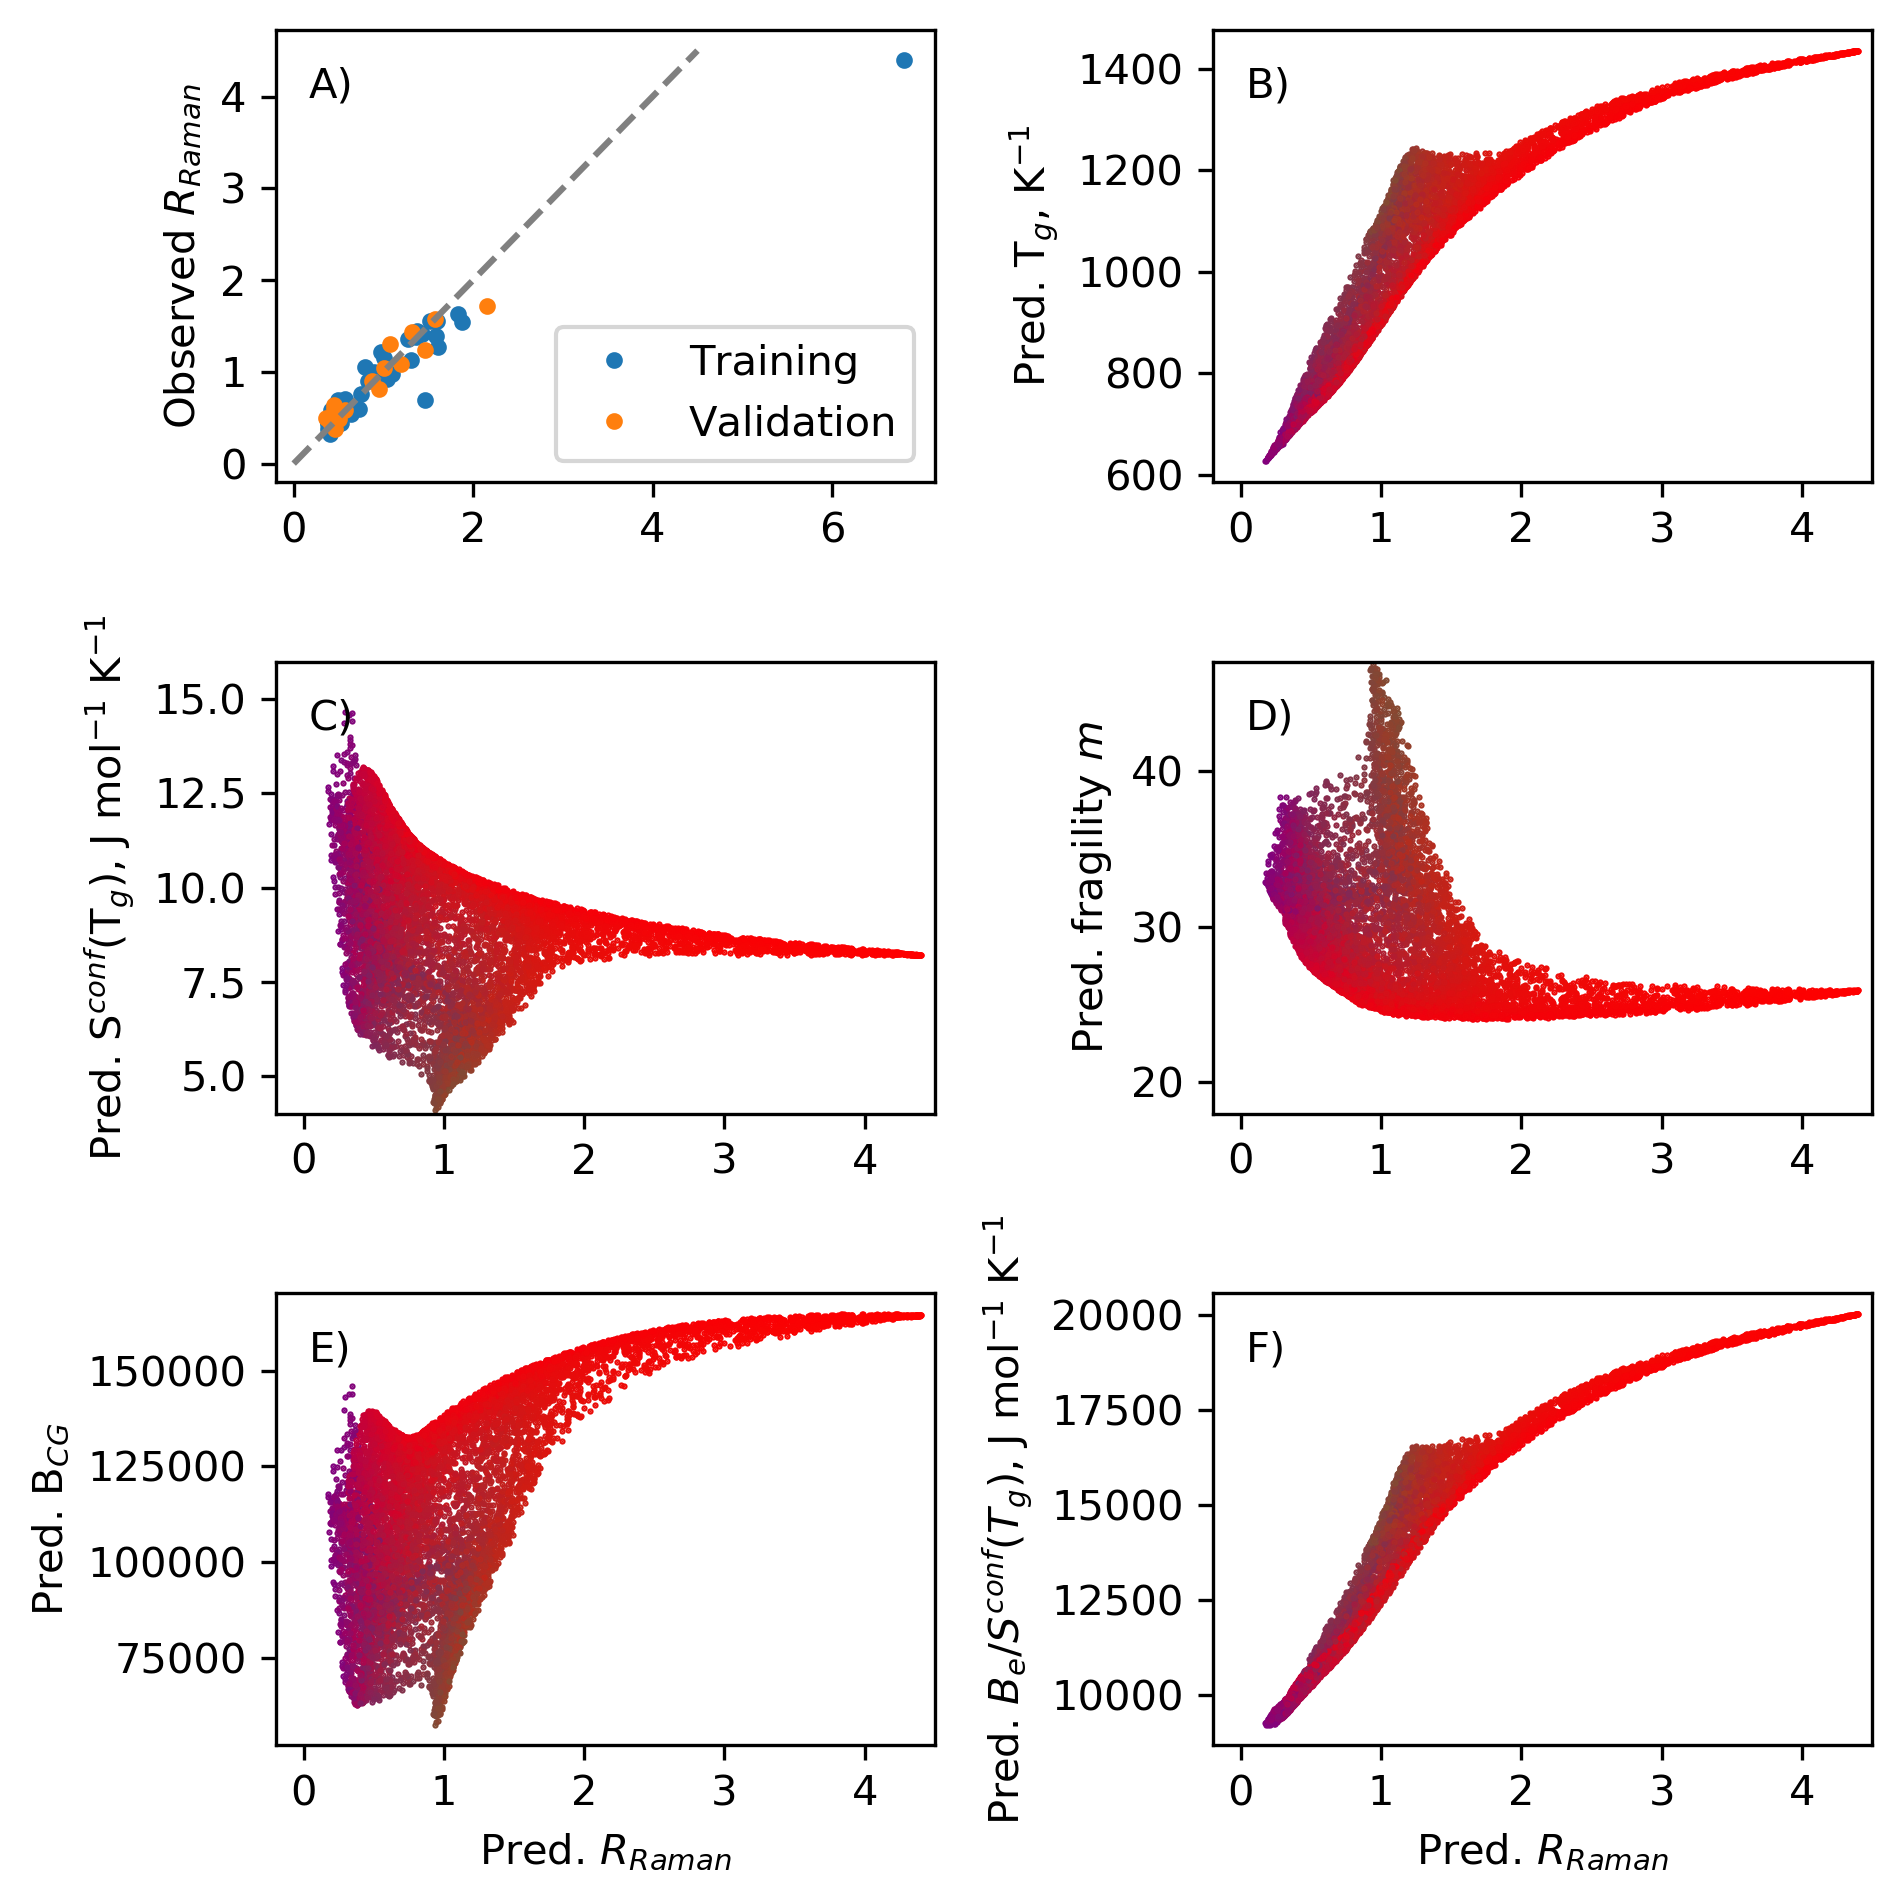

In [27]:
from tqdm import tqdm 

def plot_colored_markers(XXX, YYY, CLR):
    for i in tqdm(range(len(XXX))):
        plt.plot(XXX[i],YYY[i],".",markersize=1,color=(CLR[i,0],CLR[i,1],CLR[i,2]+CLR[i,3]))

plt.figure(figsize=(6.44,6.44),dpi=300)

plt.subplot(3,2,1)

plt.plot(Rr_train,Rr_train_pred,"s",color="C0",alpha=1,label="Training")
plt.plot(Rr_valid,Rr_valid_pred,".",color="C1",alpha=1,label="Validation")
plt.plot([0,4.5],[0,4.5],"--",color="grey")

plt.xlim(-0.2,)
plt.ylim(-0.2,)
plt.ylabel("Observed $R_{Raman}$")
plt.legend(loc="lower right")

plt.annotate("A)",xy=(0.05,0.85),xycoords="axes fraction",ha="left")

plt.subplot(3,2,2)
plot_colored_markers(Rr_gen.reshape(-1,1), neuralmodel.predict("tg",X_gen).mean(axis=1), X_gen.detach().numpy())
#print("R Rr - Tg = {}".format(np.corrcoef(np.concatenate((Rr_gen.reshape(-1,1), neuralmodel.predict("tg",X_gen).mean(axis=1)),axis=1).T)))

plt.annotate("B)",xy=(0.05,0.85),xycoords="axes fraction",ha="left")

plt.xlim(-0.2,4.5)
plt.ylabel(r"Pred. T$_{g}$, K$^{-1}$")

plt.subplot(3,2,3)
plot_colored_markers(Rr_gen.reshape(-1,1), neuralmodel.predict("sctg",X_gen).mean(axis=1), X_gen.detach().numpy())

plt.xlim(-0.2,4.5)
plt.ylim(4,16)
#plt.xlabel("Pred. $R_{Raman}$")
plt.ylabel(r"Pred. S$^{conf}$(T$_{g}$), J mol$^{-1}$ K$^{-1}$")

plt.annotate("C)",xy=(0.05,0.85),xycoords="axes fraction",ha="left")

plt.subplot(3,2,4)
plot_colored_markers(Rr_gen.reshape(-1,1), neuralmodel.predict("fragility",X_gen).mean(axis=1), X_gen.detach().numpy())

plt.xlim(-0.2,4.5)
plt.ylim(18,47)
#plt.xlabel("Pred. $R_{Raman}$")
plt.ylabel(r"Pred. fragility $m$")

#plt.ylim(5,14)

plt.annotate("D)",xy=(0.05,0.85),xycoords="axes fraction",ha="left")

plt.tight_layout()

plt.subplot(3,2,5)
plot_colored_markers(Rr_gen.reshape(-1,1), neuralmodel.predict("be",X_gen).mean(axis=1), X_gen.detach().numpy())
#print("R Rr - Bcg = {}".format(np.corrcoef(np.concatenate((Rr_gen.reshape(-1,1), neuralmodel.b_cg(X_gen).detach().numpy()),axis=1).T)))

plt.xlim(-0.2,4.5)
#plt.ylim(18,47)
plt.xlabel("Pred. $R_{Raman}$")
plt.ylabel(r"Pred. B$_{CG}$")

#plt.ylim(5,14)

plt.annotate("E)",xy=(0.05,0.85),xycoords="axes fraction",ha="left")

plt.tight_layout()

plt.subplot(3,2,6)
plot_colored_markers(Rr_gen.reshape(-1,1), neuralmodel.predict("be",X_gen).mean(axis=1)/neuralmodel.predict("sctg",X_gen).mean(axis=1), X_gen.detach().numpy())
#print("R Rr - Be/Sc = {}".format(np.corrcoef(np.concatenate((Rr_gen.reshape(-1,1), neuralmodel.be(X_gen).detach().numpy()/neuralmodel.sctg(X_gen).detach().numpy()),axis=1).T)))

plt.xlim(-0.2,4.5)

plt.xlabel("Pred. $R_{Raman}$")
plt.ylabel(r"Pred. $B_e/S^{conf}(T_g)$, J mol$^{-1}$ K$^{-1}$")

#plt.ylim(5,14)

plt.annotate("F)",xy=(0.05,0.85),xycoords="axes fraction",ha="left")

plt.tight_layout()
plt.savefig("./figures/Figure6_Raman_m_Tg.png")

# Ternary plots

In [19]:
def polycorners(ncorners=3):
    '''
    Return 2D cartesian coordinates of a regular convex polygon of a specified
    number of corners.
    Args:
        ncorners (int, optional) number of corners for the polygon (default 3).
    Returns:
        (ncorners, 2) np.ndarray of cartesian coordinates of the polygon.
    '''

    center = np.array([0.5, 0.5])
    points = []

    for i in range(ncorners):
        angle = (float(i) / ncorners) * (np.pi * 2) + (np.pi / 2)
        x = center[0] + np.cos(angle) * 0.5
        y = center[1] + np.sin(angle) * 0.5
        points.append(np.array([x, y]))

    return np.array(points)

def bary2cart(bary, corners):
    '''
    Convert barycentric coordinates to cartesian coordinates given the
    cartesian coordinates of the corners.
    Args:
        bary (np.ndarray): barycentric coordinates to convert. If this matrix
            has multiple rows, each row is interpreted as an individual
            coordinate to convert.
        corners (np.ndarray): cartesian coordinates of the corners.
    Returns:
        2-column np.ndarray of cartesian coordinates for each barycentric
        coordinate provided.
    '''

    cart = None

    if len(bary.shape) > 1 and bary.shape[1] > 1:
        cart = np.array([np.sum(b / np.sum(b) * corners.T, axis=1) for b in bary])
    else:
        cart = np.sum(bary / np.sum(bary) * corners.T, axis=1)

    return cart


In [20]:
#
# For entropy map of NAS AND KAS
#
nb_samples = 10000

sio2_gen = np.random.random_sample(nb_samples)*0.5 + 0.5
reminder = 1.0 - sio2_gen
R_MAl = np.random.random_sample(nb_samples)*(1.0-0.4) + 0.4 # ratio of alkalis to Al
al2o3_gen = (1.0 - R_MAl)*reminder
na2o_gen = 1 - sio2_gen - al2o3_gen
k2o_gen = 1 - sio2_gen - al2o3_gen

X_gen_NAS = pd.DataFrame()
X_gen_NAS["sio2"] = sio2_gen
X_gen_NAS["al2o3"] = al2o3_gen
X_gen_NAS["na2o"] = na2o_gen
X_gen_NAS["k2o"] = 0.0
X_gen_NAS_rec = X_gen_NAS.copy()

X_gen_KAS = X_gen_NAS.copy()
X_gen_KAS["k2o"] = k2o_gen
X_gen_KAS["na2o"] = 0.0
X_gen_KAS_rec = X_gen_KAS.copy()

frames = [X_gen_NAS_rec, X_gen_KAS_rec]

X_gen_NAS = torch.Tensor(X_gen_NAS.values).to(device)
X_gen_KAS = torch.Tensor(X_gen_KAS.values).to(device)
X_gen_all = torch.Tensor(pd.concat(frames).values).to(device)

cart_NAS = bary2cart(X_gen_NAS_rec.loc[:,["na2o","sio2","al2o3"]].values, corners=np.array([[0,0],[1,1],[2,0]]))
cart_KAS = bary2cart(X_gen_KAS_rec.loc[:,["k2o","sio2","al2o3"]].values, corners=np.array([[0,0],[1,1],[2,0]]))

#
# For entropy map during mixing
#

def generate_compo(sio2,R_MAl):
    
    xk = np.linspace(0.,1.,500)

    master_df = pd.DataFrame()
    master_df['sio2'] = sio2[0]*np.ones(500)
    reminder = 1 - master_df['sio2']
    master_df['al2o3'] = R_MAl * reminder
    alkalis = 1 - master_df['sio2'] - master_df['al2o3']
    master_df['na2o'] = (1-xk)*alkalis
    master_df['k2o'] = xk*alkalis
    master_df['xk'] = xk
    
    for i in range(1,len(sio2)):
        ddd = pd.DataFrame()
        ddd['sio2'] = sio2[i]*np.ones(500)
        reminder = 1 - ddd['sio2']
        ddd['al2o3'] = R_MAl * reminder
        alkalis = 1 - ddd['sio2'] - ddd['al2o3']
        ddd['na2o'] = (1-xk)*alkalis
        ddd['k2o'] = xk*alkalis
        ddd['xk'] = xk
        
        master_df = pd.concat([master_df,ddd])
        
    return master_df
        
sio2_gen = np.arange(0.5,0.99,0.01)

X_gen_RS_Xk_rec = generate_compo(sio2_gen, 0.0)
X_gen_R3_Xk_rec = generate_compo(sio2_gen, 0.25)
X_gen_R1_Xk_rec = generate_compo(sio2_gen, 0.5)


# Maps of entropy

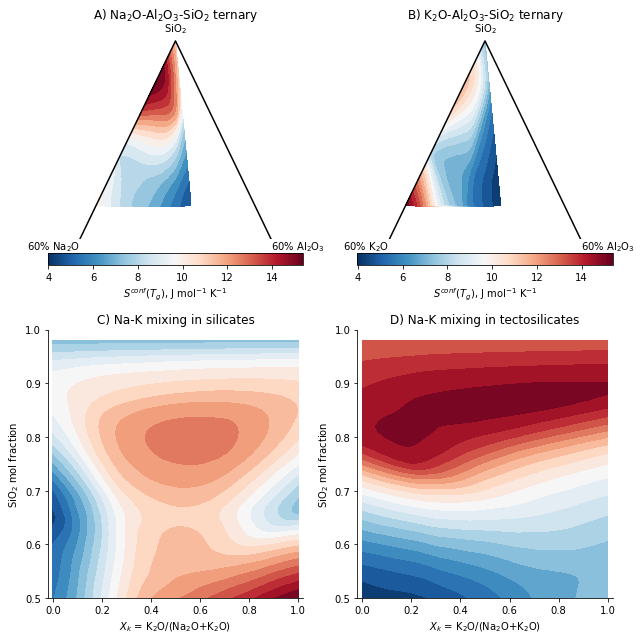

In [21]:
plt.figure(figsize=(9,9))

# grabing the entropies along NS/KS
sctg_NAS = neuralmodel.predict("sctg",X_gen_NAS).mean(axis=1)
sctg_KAS = neuralmodel.predict("sctg",X_gen_KAS).mean(axis=1)
sctg_all = neuralmodel.predict("sctg",X_gen_all).mean(axis=1)

# grabing the entropies for the mixtures
sctg_RS_Xk = neuralmodel.predict("sctg",X_gen_RS_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)
sctg_R3_Xk = neuralmodel.predict("sctg",X_gen_R3_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)
sctg_R1_Xk = neuralmodel.predict("sctg",X_gen_R1_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)

trig_color_plot = sctg_all # for the colors > same scale 

# norm is a class which, when called, can normalize data into the
# [0.0, 1.0] interval.
norm = matplotlib.colors.Normalize(
    vmin=np.min(trig_color_plot),
    vmax=np.max(trig_color_plot))

c_m = matplotlib.cm.RdBu_r # choose a colormap
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm) # create a ScalarMappable and initialize a data structure

####
#### TERNARY PLOT NAS
####
ax= plt.subplot(2,2,1)
tc1 = plt.tricontourf(cart_NAS[:,0], 
                cart_NAS[:,1], 
                sctg_NAS, 
                levels=20, cmap="RdBu_r")

#ax.scatter(cart_NAS[:,0],cart_NAS[:,1],s=1,c="k", cmap="RdBu_r")
ax.plot([0,1,2,0],[0,1,0,0],"k-")

ax.set_xlim(0.2,1.8)
ax.set_ylim(0.4,1.05)

plt.annotate(r"SiO$_2$", xy = (1,1.03),xycoords="data",ha="center")
plt.annotate(r"60% Al$_2$O$_3$", xy = (1.6,0.4),xycoords="data",ha="left",va="top")
plt.annotate(r"60% Na$_2$O", xy = (0.4,0.4),xycoords="data",ha="right",va="top")

ax.axis("off")

cbar_0 = plt.colorbar(mappable=s_m,orientation="horizontal",pad=0.05)
cbar_0.set_label(r"$S^{conf}(T{_g})$, J mol$^{-1}$ K$^{-1}$")

ax.set_title("A) Na$_2$O-Al$_2$O$_3$-SiO$_2$ ternary", loc='center')

plt.tight_layout()

####
#### TERNARY PLOT KAS
####
ax= plt.subplot(2,2,2)
tc1 = plt.tricontourf(cart_KAS[:,0], 
                cart_KAS[:,1], 
                sctg_KAS, 
                levels=20, cmap="RdBu_r")

#ax.scatter(cart_NAS[:,0],cart_NAS[:,1],s=1,c="k", cmap="RdBu_r")
ax.plot([0,1,2,0],[0,1,0,0],"k-")

ax.set_xlim(0.2,1.8)
ax.set_ylim(0.4,1.05)

plt.annotate(r"SiO$_2$", xy = (1,1.03),xycoords="data",ha="center")
plt.annotate(r"60% Al$_2$O$_3$", xy = (1.6,0.4),xycoords="data",ha="left",va="top")
plt.annotate(r"60% K$_2$O", xy = (0.4,0.4),xycoords="data",ha="right",va="top")

ax.axis("off")
 
cbar_0 = plt.colorbar(mappable=s_m,orientation="horizontal",pad=0.05)
cbar_0.set_label(r"$S^{conf}(T{_g})$, J mol$^{-1}$ K$^{-1}$")

ax.set_title("B) K$_2$O-Al$_2$O$_3$-SiO$_2$ ternary", loc='center')

plt.tight_layout()

####
#### XK along near tectosilicate joint
####
ax= plt.subplot(2,2,3)
tc1 = plt.tricontourf(X_gen_RS_Xk_rec.loc[:,"xk"], 
                X_gen_RS_Xk_rec.loc[:,"sio2"], 
                sctg_RS_Xk, 
                levels=20, cmap="RdBu_r")

#ax.scatter(cart_KAS[:,0],cart_KAS[:,1],s=1,c="k", cmap="RdBu_r")
ax.set_xlim(-0.02,1.02)
ax.set_ylim(0.5,1.)

plt.xlabel(r"$X_k$ = K$_2$O/(Na$_2$O+K$_2$O)")
plt.ylabel(r"SiO$_2$ mol fraction")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#ax.axis('off') 
#cbar_0 = plt.colorbar(mappable=s_m,orientation="horizontal",pad=0.05)
#cbar_0.set_label(r"$S^{conf}(T{_g})$, J mol$^{-1}$ K$^{-1}$")

ax.set_title("C) Na-K mixing in silicates", loc='center')

plt.tight_layout()

####
#### XK along near tectosilicate joint
####
ax= plt.subplot(2,2,4)
tc1 = plt.tricontourf(X_gen_R1_Xk_rec.loc[:,"xk"], 
                X_gen_R1_Xk_rec.loc[:,"sio2"], 
                sctg_R1_Xk, 
                levels=20, cmap="RdBu_r")

#ax.scatter(cart_KAS[:,0],cart_KAS[:,1],s=1,c="k", cmap="RdBu_r")
ax.set_xlim(-0.02,1.02)
ax.set_ylim(0.5,1.)

plt.xlabel(r"$X_k$ = K$_2$O/(Na$_2$O+K$_2$O)")
plt.ylabel(r"SiO$_2$ mol fraction")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#cbar_0 = plt.colorbar(mappable=s_m,orientation="vertical",pad=0.05)
#cbar_0.set_label(r"$S^{conf}(T{_g})$, J mol$^{-1}$ K$^{-1}$")

ax.set_title("D) Na-K mixing in tectosilicates", loc='center')

plt.tight_layout()

plt.savefig("./figures/Figure4_entromaps.png")

# Maps of fragility, density, refractive index

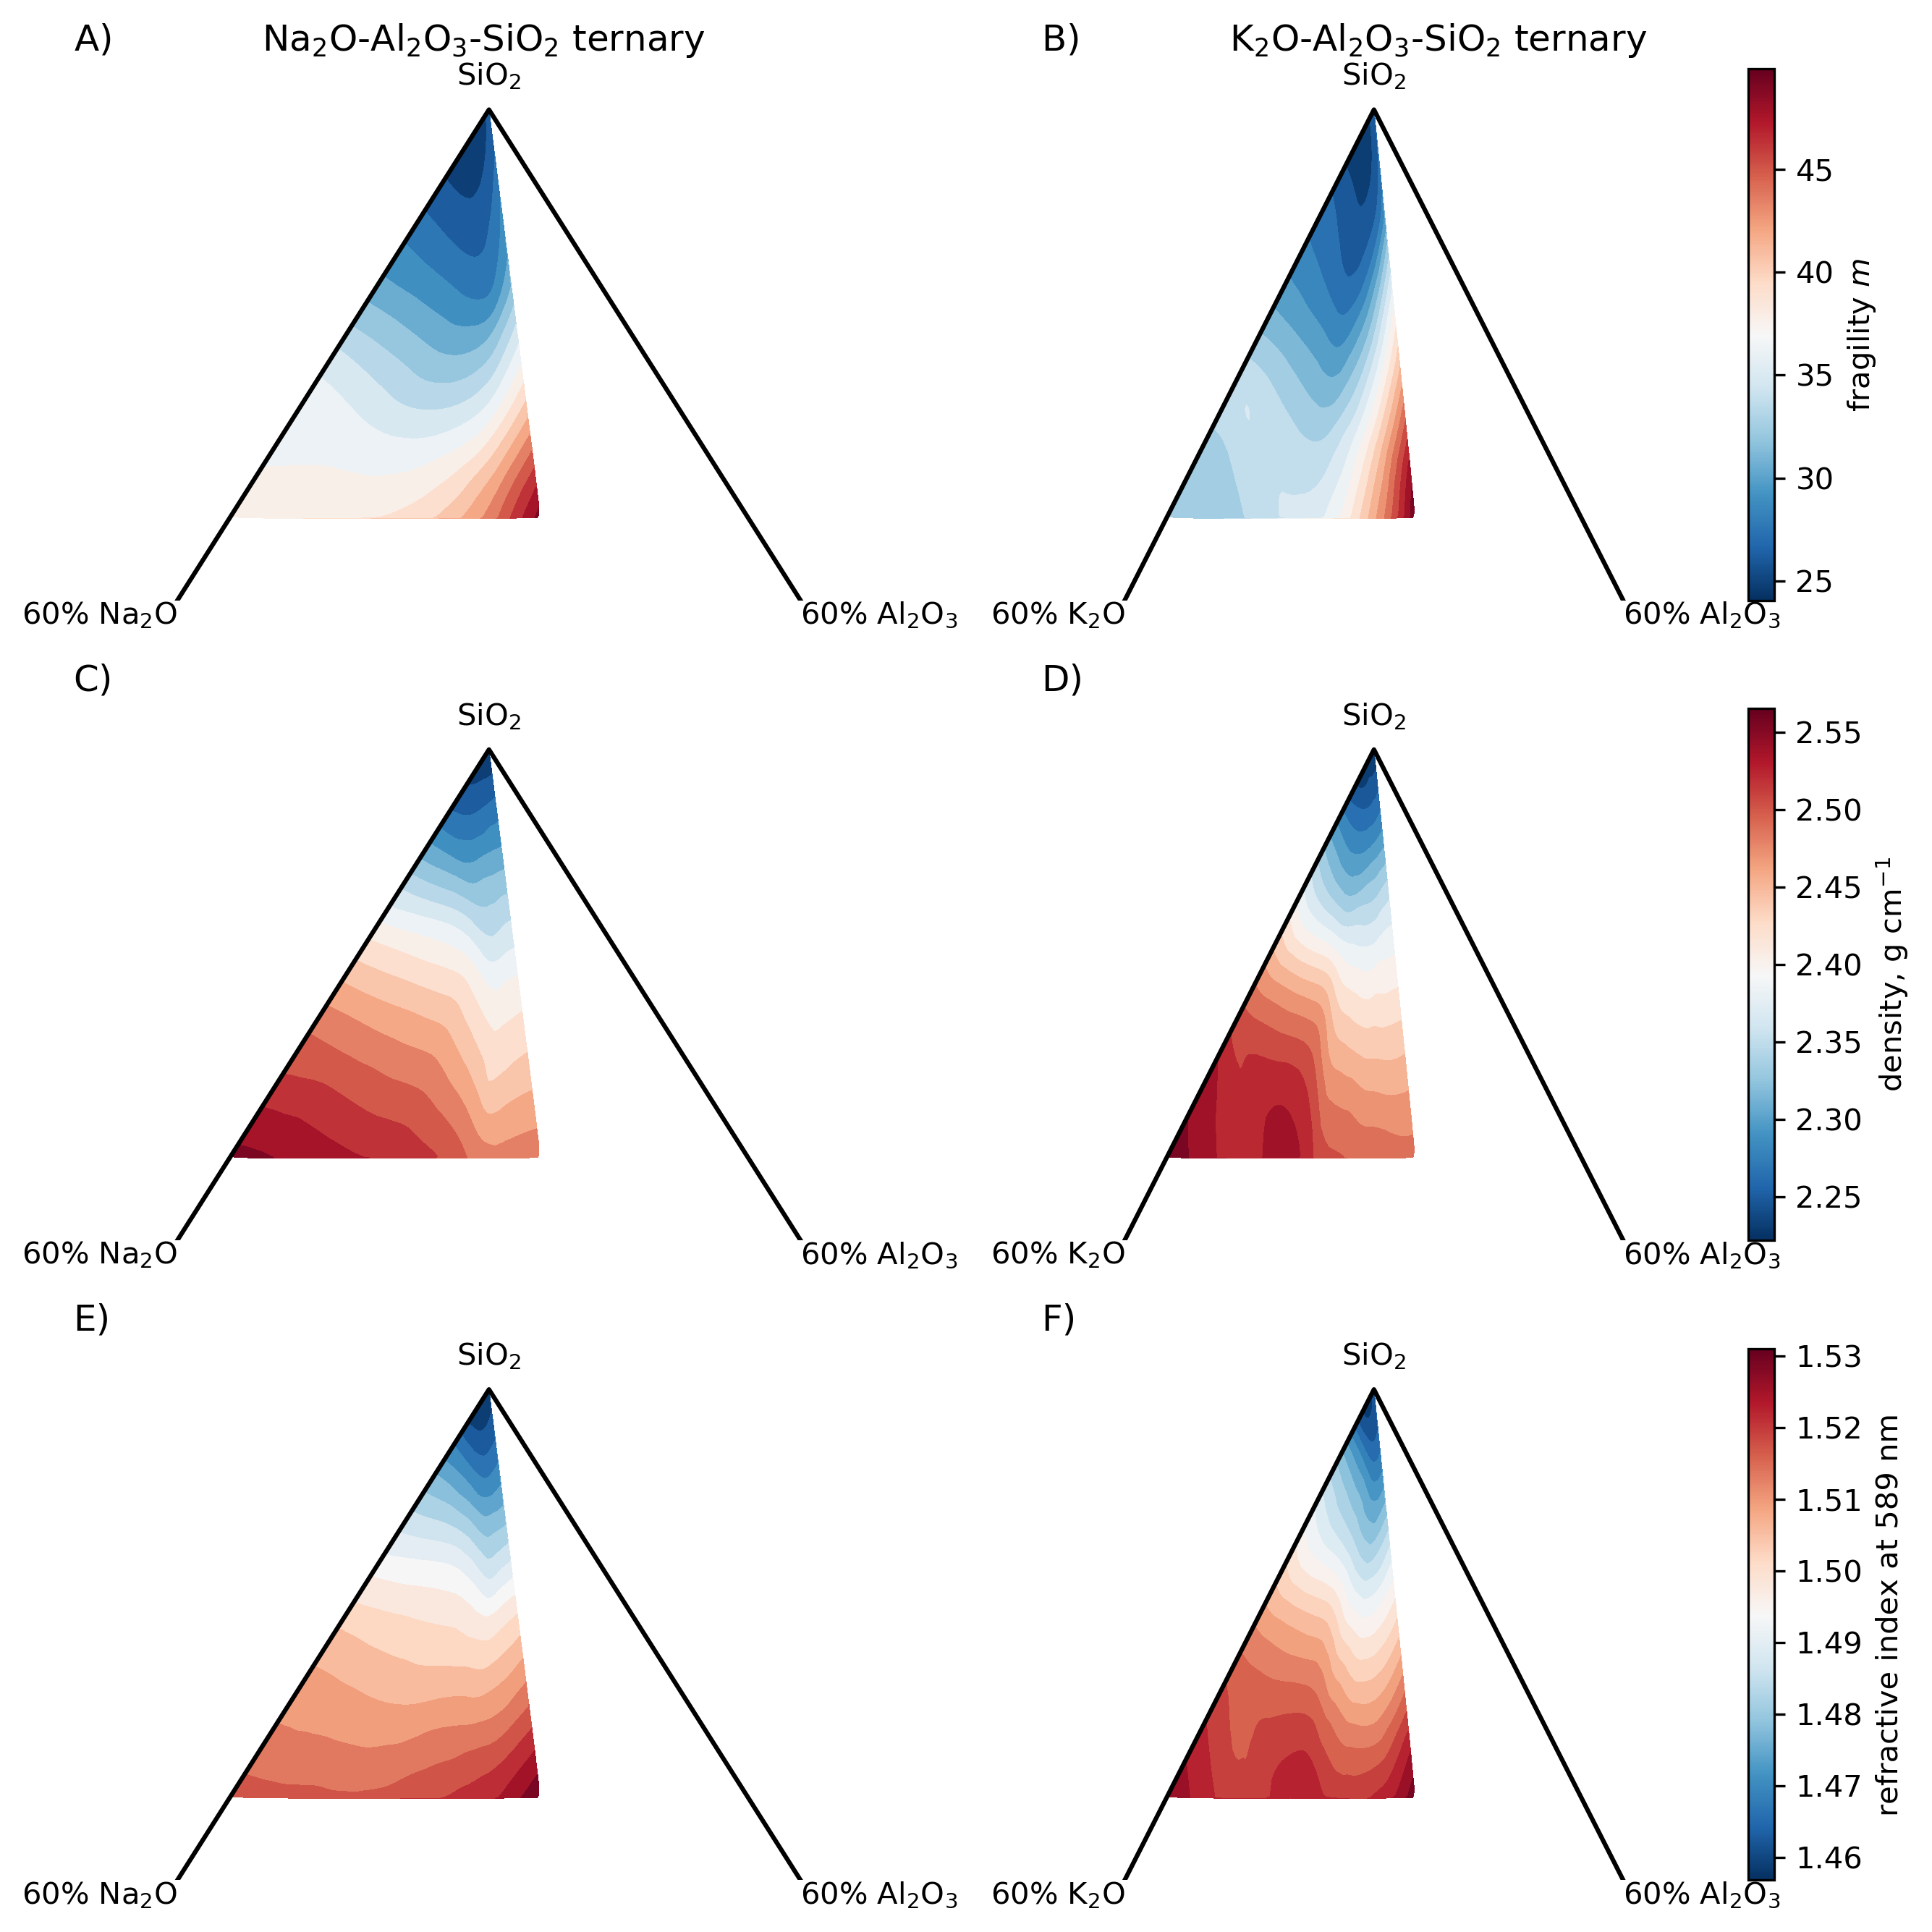

In [44]:
plt.figure(figsize=(9,9), dpi=300)

# grabing the predictions in NAS and KAS
m_NAS = neuralmodel.predict("fragility",X_gen_NAS).mean(axis=1)
m_KAS = neuralmodel.predict("fragility",X_gen_KAS).mean(axis=1)
m_all = neuralmodel.predict("fragility",X_gen_all).mean(axis=1)

d_NAS = neuralmodel.predict("density",X_gen_NAS).mean(axis=1)
d_KAS = neuralmodel.predict("density",X_gen_KAS).mean(axis=1)
d_all = neuralmodel.predict("density",X_gen_all).mean(axis=1)

n_NAS = neuralmodel.predict("sellmeier",X_gen_NAS,lbd=np.ones((len(X_gen_NAS),1))*0.589).mean(axis=1)
n_KAS = neuralmodel.predict("sellmeier",X_gen_KAS,lbd=np.ones((len(X_gen_KAS),1))*0.589).mean(axis=1)
n_all = neuralmodel.predict("sellmeier",X_gen_all,lbd=np.ones((len(X_gen_all),1))*0.589).mean(axis=1)

# choose a colormap
c_m = matplotlib.cm.RdBu_r 

#### Scalar Mappables for color bars
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, 
                                   norm=matplotlib.colors.Normalize(
                                                                    vmin=np.min(m_all),
                                                                    vmax=np.max(m_all))) # create a ScalarMappable and initialize a data structure
s_d = matplotlib.cm.ScalarMappable(cmap=c_m, 
                                   norm=matplotlib.colors.Normalize(
                                                                    vmin=np.min(d_all),
                                                                    vmax=np.max(d_all))) # create a ScalarMappable and initialize a data structure

s_n = matplotlib.cm.ScalarMappable(cmap=c_m, 
                                   norm=matplotlib.colors.Normalize(
                                                                    vmin=np.min(n_all),
                                                                    vmax=np.max(n_all))) # create a ScalarMappable and initialize a data structure

####
#### NAS FRAGILITY TERNARY PLOT
####
ax= plt.subplot(3,2,1)

tc1 = plt.tricontourf(cart_NAS[:,0], cart_NAS[:,1], m_NAS, levels=20, cmap="RdBu_r")
ax.plot([0,1,2,0],[0,1,0,0],"k-")
#cbar_0 = plt.colorbar(mappable=s_m,orientation="horizontal",pad=0.05)
#cbar_0.set_label(r"fragility $m$")

ax.axis("off")
ax.set_xlim(0.2,1.8)
ax.set_ylim(0.4,1.05)

plt.annotate(r"SiO$_2$", xy = (1,1.03),xycoords="data",ha="center")
plt.annotate(r"60% Al$_2$O$_3$", xy = (1.6,0.4),xycoords="data",ha="left",va="top")
plt.annotate(r"60% Na$_2$O", xy = (0.4,0.4),xycoords="data",ha="right",va="top")
ax.set_title("A)             Na$_2$O-Al$_2$O$_3$-SiO$_2$ ternary", loc='left')

plt.tight_layout()

####
#### KAS FRAGILITY TERNARY PLOT
####
ax= plt.subplot(3,2,2)

tc1 = plt.tricontourf(cart_KAS[:,0], cart_KAS[:,1], m_KAS, levels=20, cmap="RdBu_r")
ax.plot([0,1,2,0],[0,1,0,0],"k-")
cbar_0 = plt.colorbar(mappable=s_m,orientation="vertical",pad=0.05)
cbar_0.set_label(r"fragility $m$")

ax.axis("off")
ax.set_xlim(0.2,1.8)
ax.set_ylim(0.4,1.05)

plt.annotate(r"SiO$_2$", xy = (1,1.03),xycoords="data",ha="center")
plt.annotate(r"60% Al$_2$O$_3$", xy = (1.6,0.4),xycoords="data",ha="left",va="top")
plt.annotate(r"60% K$_2$O", xy = (0.4,0.4),xycoords="data",ha="right",va="top")
ax.set_title("B)             K$_2$O-Al$_2$O$_3$-SiO$_2$ ternary", loc='left')

plt.tight_layout()

####
#### NAS DENSITY TERNARY PLOT
####
ax= plt.subplot(3,2,3)
tc1 = plt.tricontourf(cart_NAS[:,0], cart_NAS[:,1], d_NAS, levels=20, cmap="RdBu_r")
ax.plot([0,1,2,0],[0,1,0,0],"k-")
#cbar_0 = plt.colorbar(mappable=s_d,orientation="horizontal",pad=0.05)
#cbar_0.set_label(r"density, g cm$^{-1}$")

ax.axis("off")
ax.set_xlim(0.2,1.8)
ax.set_ylim(0.4,1.05)

plt.annotate(r"SiO$_2$", xy = (1,1.03),xycoords="data",ha="center")
plt.annotate(r"60% Al$_2$O$_3$", xy = (1.6,0.4),xycoords="data",ha="left",va="top")
plt.annotate(r"60% Na$_2$O", xy = (0.4,0.4),xycoords="data",ha="right",va="top")
ax.set_title("C)", loc='left')

plt.tight_layout()

####
#### KAS DENSITY TERNARY PLOT
####
ax= plt.subplot(3,2,4)
tc1 = plt.tricontourf(cart_KAS[:,0], cart_KAS[:,1], d_KAS, levels=20, cmap="RdBu_r")
ax.plot([0,1,2,0],[0,1,0,0],"k-")
cbar_0 = plt.colorbar(mappable=s_d,orientation="vertical",pad=0.05)
cbar_0.set_label(r"density, g cm$^{-1}$")

ax.axis("off")
ax.set_xlim(0.2,1.8)
ax.set_ylim(0.4,1.05)

plt.annotate(r"SiO$_2$", xy = (1,1.03),xycoords="data",ha="center")
plt.annotate(r"60% Al$_2$O$_3$", xy = (1.6,0.4),xycoords="data",ha="left",va="top")
plt.annotate(r"60% K$_2$O", xy = (0.4,0.4),xycoords="data",ha="right",va="top")
ax.set_title("D)", loc='left')

plt.tight_layout()

####
#### NAS OPTIC TERNARY PLOT
####
ax= plt.subplot(3,2,5)
tc1 = plt.tricontourf(cart_NAS[:,0], cart_NAS[:,1], n_NAS, levels=20, cmap="RdBu_r")
ax.plot([0,1,2,0],[0,1,0,0],"k-")
#cbar_0 = plt.colorbar(mappable=s_n,orientation="horizontal",pad=0.05)
#cbar_0.set_label(r"m")

ax.axis("off")
ax.set_xlim(0.2,1.8)
ax.set_ylim(0.4,1.05)

plt.annotate(r"SiO$_2$", xy = (1,1.03),xycoords="data",ha="center")
plt.annotate(r"60% Al$_2$O$_3$", xy = (1.6,0.4),xycoords="data",ha="left",va="top")
plt.annotate(r"60% Na$_2$O", xy = (0.4,0.4),xycoords="data",ha="right",va="top")
ax.set_title("E)", loc='left')

plt.tight_layout()

####
#### KAS FRAGILITY TERNARY PLOT
####
ax= plt.subplot(3,2,6)
tc1 = plt.tricontourf(cart_KAS[:,0], cart_KAS[:,1], n_KAS, levels=20, cmap="RdBu_r")
ax.plot([0,1,2,0],[0,1,0,0],"k-")
cbar_0 = plt.colorbar(mappable=s_n,orientation="vertical",pad=0.05)
cbar_0.set_label(r"refractive index at 589 nm")

ax.axis("off")
ax.set_xlim(0.2,1.8)
ax.set_ylim(0.4,1.05)

plt.annotate(r"SiO$_2$", xy = (1,1.03),xycoords="data",ha="center")
plt.annotate(r"60% Al$_2$O$_3$", xy = (1.6,0.4),xycoords="data",ha="left",va="top")
plt.annotate(r"60% K$_2$O", xy = (0.4,0.4),xycoords="data",ha="right",va="top")

ax.set_title("F)", loc='left')

plt.tight_layout()

plt.savefig("./figures/Figure5_fragility_maps.png")

# Map for fragility vs XK

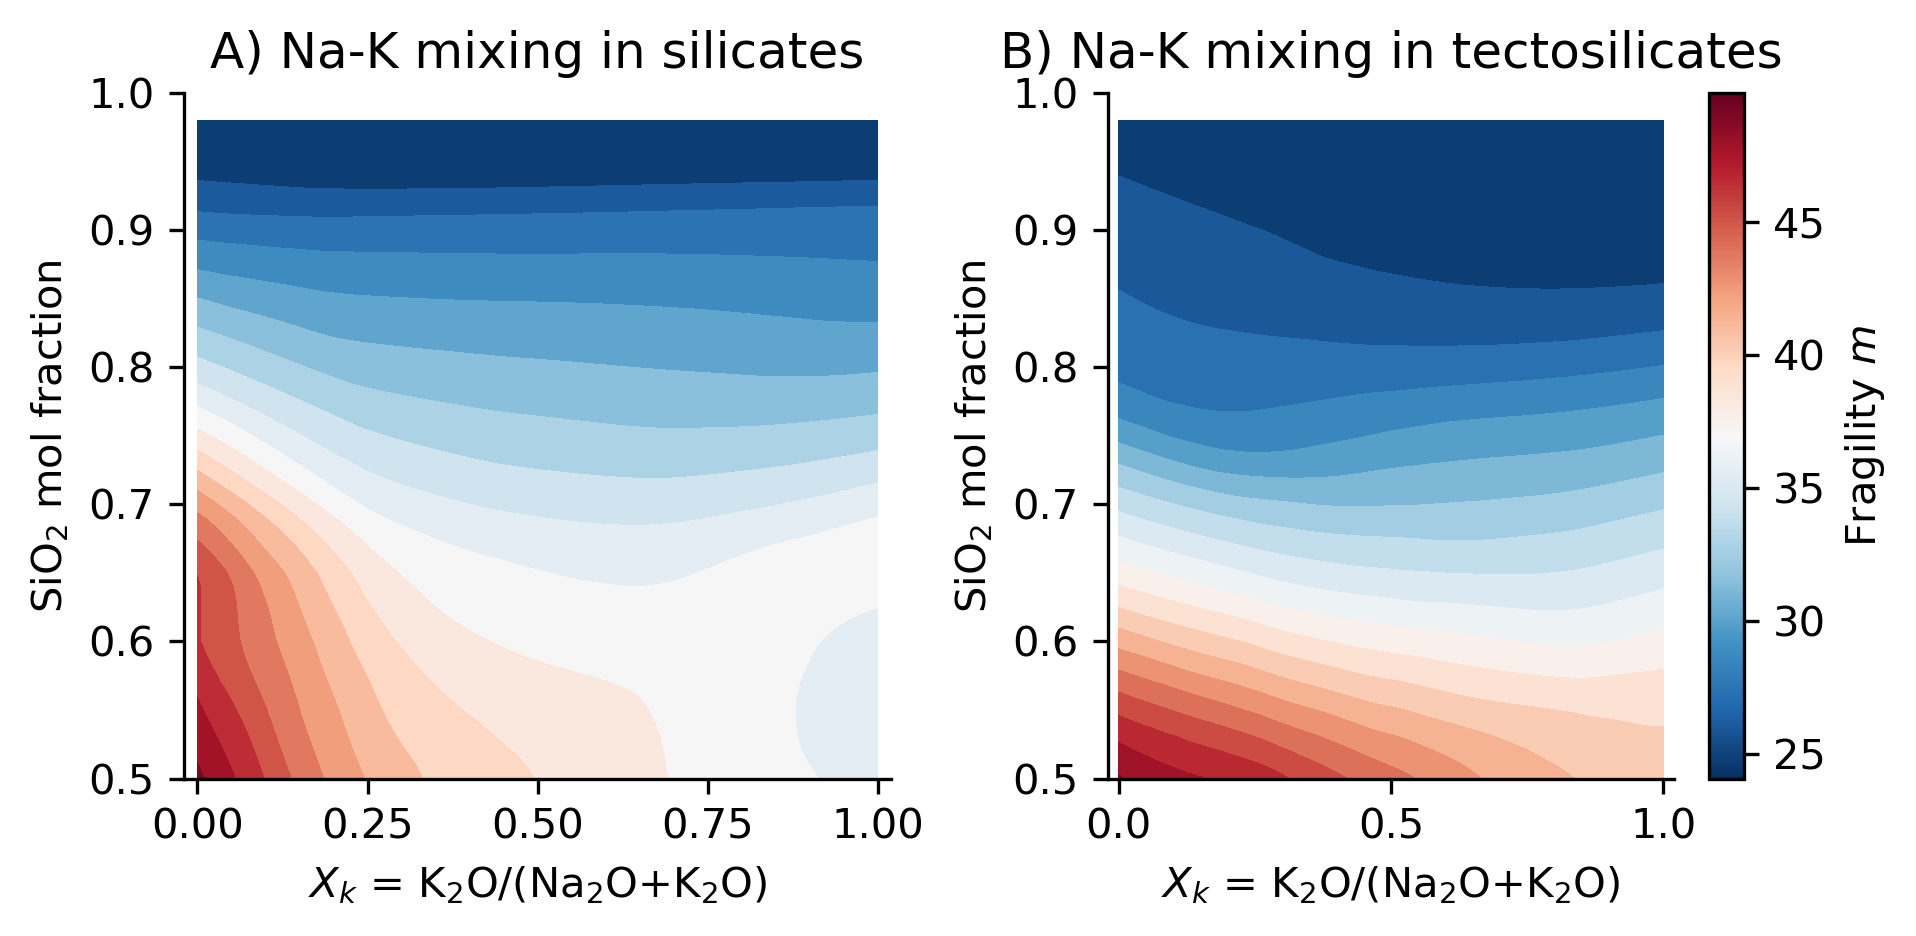

In [49]:
# grabing the entropies for the mixtures
m_RS_Xk = neuralmodel.predict("fragility",X_gen_RS_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)
m_R3_Xk = neuralmodel.predict("fragility",X_gen_R3_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)
m_R1_Xk = neuralmodel.predict("fragility",X_gen_R1_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)


####
#### XK along near tectosilicate joint
####
plt.figure(figsize=(6.44,3.22),dpi=300)
ax= plt.subplot(1,2,1)
tc1 = plt.tricontourf(X_gen_RS_Xk_rec.loc[:,"xk"], 
                X_gen_RS_Xk_rec.loc[:,"sio2"], 
                m_RS_Xk, 
                levels=20, cmap="RdBu_r")

#ax.scatter(cart_KAS[:,0],cart_KAS[:,1],s=1,c="k", cmap="RdBu_r")
ax.set_xlim(-0.02,1.02)
ax.set_ylim(0.5,1.)

plt.xlabel(r"$X_k$ = K$_2$O/(Na$_2$O+K$_2$O)")
plt.ylabel(r"SiO$_2$ mol fraction")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#ax.axis('off') 
#cbar_0 = plt.colorbar(mappable=s_m,orientation="horizontal",pad=0.05)
#cbar_0.set_label(r"$S^{conf}(T{_g})$, J mol$^{-1}$ K$^{-1}$")

ax.set_title("A) Na-K mixing in silicates", loc='center')

plt.tight_layout()

####
#### XK along near tectosilicate joint
####
ax= plt.subplot(1,2,2)
tc1 = plt.tricontourf(X_gen_R1_Xk_rec.loc[:,"xk"], 
                X_gen_R1_Xk_rec.loc[:,"sio2"], 
                m_R1_Xk, 
                levels=20, cmap="RdBu_r")

#ax.scatter(cart_KAS[:,0],cart_KAS[:,1],s=1,c="k", cmap="RdBu_r")
ax.set_xlim(-0.02,1.02)
ax.set_ylim(0.5,1.)

plt.xlabel(r"$X_k$ = K$_2$O/(Na$_2$O+K$_2$O)")
plt.ylabel(r"SiO$_2$ mol fraction")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

cbar_0 = plt.colorbar(mappable=s_m,orientation="vertical",pad=0.05)
cbar_0.set_label(r"Fragility $m$")

ax.set_title("B) Na-K mixing in tectosilicates", loc='center')

plt.tight_layout()

plt.savefig("./figures/SupplementaryFigure5.png")